In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import pandas as pd
import zipfile
import IPython.display as ipd
import soundfile as sf
import glob
import parselmouth
from parselmouth.praat import call
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier ,GradientBoostingClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score ,recall_score,precision_score,f1_score
from sklearn.model_selection import KFold, cross_val_score,train_test_split
import seaborn as sns
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import librosa
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder
import torchaudio
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor
import torchaudio
import torch
from transformers import Wav2Vec2Processor, Wav2Vec2Model
from tqdm import tqdm

In [18]:
class SNRSegmenter(object):

    def __init__(self, sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr):
        self.segment_len_samples = int(sample_rate * segment_len_ms / 1000)
        self.hop_len_samples = int(sample_rate * hop_len_ms / 1000)
        self.noise_len_samples = int(sample_rate * noise_len_ms / 1000)

        self.call_snr = call_snr

    def _get_noise_level(self, sample):
        abs_max = []

        if len(sample) > self.noise_len_samples:
            idx = 0
            while idx + self.noise_len_samples < len(sample):
                abs_max.append(np.max(np.abs(sample[idx:(idx+self.noise_len_samples)])))
                idx += self.noise_len_samples
        else:
            abs_max.append(np.max(np.abs(sample)))

        return min(abs_max)

    def __call__(self, sample):

        noise_level = self._get_noise_level(sample)

        call_segments = []
        call_snrs = []

        if len(sample) > self.segment_len_samples:
            idx = 0
            while idx + self.segment_len_samples < len(sample):
                segment = sample[idx:(idx+self.segment_len_samples)]
                seg_abs_max = np.max(np.abs(segment))
                if seg_abs_max / noise_level > self.call_snr:
                    call_segments.append(segment)
                    call_snrs.append(seg_abs_max / noise_level)

                idx += self.hop_len_samples

        return call_segments, call_snrs



In [19]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/SpontaneousDialogue"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 15

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 # if len(subentry)>18:
#                 #     temp = subentry[:9]+ "_2_"
#                 # else:
#                 #     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2,subentry[:9]+ "_" )
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [20]:
# import os

# directory_path = "C:/Users/Vishal/Desktop/btps8e02/Dataset/MDVRKCL/Readtext"

# path2 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"


# root = os.listdir(directory_path)

# for entry in root:
#     # print(entry)
#     subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
#     subdir_path2 = os.path.join(path2, entry)
#     # print(subdir_path)
#     if os.path.isdir(subdir_path):  # check if it is a folder
#         subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
#         for subentry in subdir_entries:
#             wav_file = os.path.join(subdir_path, subentry)  # absolute path of the subentry
#             y, sample_rate = librosa.load(wav_file)
#             # Calculate the current DC offset (mean of the audio signal)
#             dc_offset = np.mean(y)

# # Apply the DC shift
#             y_shifted = y - dc_offset

#             audio = librosa.util.normalize(y_shifted)
#             segment_len_ms = 2500
#             hop_len_ms = 1000
#             noise_len_ms = 500
#             call_snr_thresh = 5

#             segmenter = SNRSegmenter(sample_rate, segment_len_ms, hop_len_ms, noise_len_ms, call_snr_thresh)

#             calls, call_snrs = segmenter(audio)
#             h=1
#             for i in calls:
#                 if len(subentry)>18:
#                     temp = subentry[:9]+ "_2_"
#                 else:
#                     temp = subentry[:9]+ "_1_"
#                 file = os.path.join(subdir_path2, temp)
#                 # if(subentry[:4]=='ID05'):
#                 #     print(len(subentry))
#                 #     print(file)
#                 sf.write(file+str(h)+".wav",i,sample_rate)
#                 h = h+1


In [2]:
def measurePitch(voiceID, f0min, f0max, unit):
    sound = parselmouth.Sound(voiceID) # read the sound
    pitch = call(sound, "To Pitch", 0.0, f0min, f0max) #create a praat pitch object
    meanF0 = call(pitch, "Get mean", 0, 0, unit) # get mean pitch
    stdevF0 = call(pitch, "Get standard deviation", 0 ,0, unit) # get standard deviation
    harmonicity = call(sound, "To Harmonicity (cc)", 0.01, 75, 0.1, 1.0)
    hnr = call(harmonicity, "Get mean", 0, 0)
    pointProcess = call(sound, "To PointProcess (periodic, cc)", f0min, f0max)
    localJitter = call(pointProcess, "Get jitter (local)", 0, 0, 0.0001, 0.02, 1.3)
    localabsoluteJitter = call(pointProcess, "Get jitter (local, absolute)", 0, 0, 0.0001, 0.02, 1.3)
    rapJitter = call(pointProcess, "Get jitter (rap)", 0, 0, 0.0001, 0.02, 1.3)
    ppq5Jitter = call(pointProcess, "Get jitter (ppq5)", 0, 0, 0.0001, 0.02, 1.3)
    ddpJitter = call(pointProcess, "Get jitter (ddp)", 0, 0, 0.0001, 0.02, 1.3)
    localShimmer =  call([sound, pointProcess], "Get shimmer (local)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    localdbShimmer = call([sound, pointProcess], "Get shimmer (local_dB)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq3Shimmer = call([sound, pointProcess], "Get shimmer (apq3)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    aqpq5Shimmer = call([sound, pointProcess], "Get shimmer (apq5)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    apq11Shimmer =  call([sound, pointProcess], "Get shimmer (apq11)", 0, 0, 0.0001, 0.02, 1.3, 1.6)
    ddaShimmer = call([sound, pointProcess], "Get shimmer (dda)", 0, 0, 0.0001, 0.02, 1.3, 1.6)


    return meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer

In [3]:
def runPCA(df):
    #Z-score the Jitter and Shimmer measurements
    features = ['localJitter', 'localabsoluteJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter',
                'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer']
    # Separating out the features
    x = df.loc[:, features].values
    # Separating out the target
    #y = df.loc[:,['target']].values
    # Standardizing the features
    x = StandardScaler().fit_transform(x)
    #PCA
    pca = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('pca', PCA(n_components=2))  # Perform PCA
])
    # pca = PCA(n_components=2)
    principalComponents = pca.fit_transform(x)
    principalDf = pd.DataFrame(data = principalComponents, columns = ['JitterPCA', 'ShimmerPCA'])
    principalDf
    return principalDf

In [4]:
# processor = Wav2Vec2Processor.from_pretrained("Pongsathorn/wav2vec2_56000")
# feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained("Pongsathorn/wav2vec2_56000")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h")


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list = []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list = []
disease=[]
mfcc =[]
trans =[]


directory_path = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/Readtext"
root = os.listdir(directory_path)

for entry in root:
    # print(entry)
    subdir_path = os.path.join(directory_path, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file ,sr =16000)
            mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            mfcc.append(mfc)
            # input_values = feature_extractor(sample, sampling_rate=rate, return_tensors="pt").input_values
            # processed_features = processor(input_values, sampling_rate=rate)
            # embeddings = np.array(processed_features.input_values).flatten()
            # Load audio file
            # audio_input, sample_rate = torchaudio.load(wav_file)
            # Preprocess audio
            inputs = processor(sample,sampling_rate=rate, return_tensors="pt", padding=True)
            # Remove extra dimensions if present
            inputs["input_values"] = inputs["input_values"]
            # Model inference
            with torch.no_grad():
                outputs = model(**inputs)
            # Extract embeddings
            last_hidden_states = outputs.last_hidden_state[0]
            last_hidden_states_np = last_hidden_states.numpy()
            embeddings = np.mean(last_hidden_states_np, axis=0)
            trans.append(embeddings)


 #adding the lists to pandas in the right order
data = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [25]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0


In [26]:
np.shape(trans)

(3949, 768)

In [27]:
np.shape(mfcc)

(3949, 13, 79)

In [5]:
# create lists to put the results
file_list = []
mean_F0_list = []
sd_F0_list = []
hnr_list = []
localJitter_list = []
localabsoluteJitter_list = []
rapJitter_list = []
ppq5Jitter_list = []
ddpJitter_list = []
localShimmer_list= []
localdbShimmer_list = []
apq3Shimmer_list = []
aqpq5Shimmer_list = []
apq11Shimmer_list = []
ddaShimmer_list= []
disease=[]
mfcc1 =[]
trans1 = []


directory_path1 = "C:/Users/Vishal/Desktop/btps8e02/Codes/SBSSS/Dataset/MDVRKCL/SpontaneousDialogue"
root1 = os.listdir(directory_path1)

for entry in root1:
    # print(entry)
    subdir_path = os.path.join(directory_path1, entry) #  create the absolute path of the subdir
     # print(subdir_path)
    if os.path.isdir(subdir_path):  # check if it is a folder
        subdir_entries = os.listdir(subdir_path)  # get the content of the subdir
        for subentry in subdir_entries:
            wav_file = os.path.join(subdir_path, subentry)
            sound = parselmouth.Sound(wav_file)
            (meanF0, stdevF0, hnr, localJitter, localabsoluteJitter, rapJitter, ppq5Jitter, ddpJitter, localShimmer, localdbShimmer, apq3Shimmer, aqpq5Shimmer, apq11Shimmer, ddaShimmer) = measurePitch(sound, 75, 500, "Hertz")
            file_list.append(subentry) # make an ID list
            mean_F0_list.append(meanF0) # make a mean F0 list
            sd_F0_list.append(stdevF0) # make a sd F0 list
            hnr_list.append(hnr)
            localJitter_list.append(localJitter)
            localabsoluteJitter_list.append(localabsoluteJitter)
            rapJitter_list.append(rapJitter)
            ppq5Jitter_list.append(ppq5Jitter)
            ddpJitter_list.append(ddpJitter)
            localShimmer_list.append(localShimmer)
            localdbShimmer_list.append(localdbShimmer)
            apq3Shimmer_list.append(apq3Shimmer)
            aqpq5Shimmer_list.append(aqpq5Shimmer)
            apq11Shimmer_list.append(apq11Shimmer)
            ddaShimmer_list.append(ddaShimmer)
            if(subentry[5] == 'p'):
                disease.append(1)
            else:
                disease.append(0)
            sample , rate = librosa.load(wav_file ,sr =16000)
            mfc = librosa.feature.mfcc(y= sample, sr= rate,n_mfcc =13)
            mfcc1.append(mfc)
            # input_values = feature_extractor(sample, sampling_rate=rate, return_tensors="pt").input_values
            # processed_features = processor(input_values, sampling_rate=rate)
            # embeddings = np.array(processed_features.input_values).flatten()
            # Load audio file
            # audio_input, sample_rate = torchaudio.load(wav_file)
            # Preprocess audio
            inputs = processor(sample,sampling_rate=rate, return_tensors="pt", padding=True)
            # Remove extra dimensions if present
            inputs["input_values"] = inputs["input_values"]
            # Model inference
            with torch.no_grad():
                outputs = model(**inputs)
            # Extract embeddings
            last_hidden_states = outputs.last_hidden_state[0]
            last_hidden_states_np = last_hidden_states.numpy()
            embeddings = np.mean(last_hidden_states_np, axis=0)
            trans1.append(embeddings)

 #adding the lists to pandas in the right order
data1 = pd.DataFrame(np.column_stack([file_list, mean_F0_list, sd_F0_list, hnr_list, localJitter_list, rapJitter_list, localabsoluteJitter_list, ppq5Jitter_list, ddpJitter_list, localShimmer_list, localdbShimmer_list, apq3Shimmer_list, aqpq5Shimmer_list, apq11Shimmer_list, ddaShimmer_list,disease]),
                               columns=['voiceID', 'meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter',  'rapJitter','localabsoluteJitter',
                                        'ppq5Jitter', 'ddpJitter', 'localShimmer', 'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer',
                                        'apq11Shimmer', 'ddaShimmer','health_status'])


In [29]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status
0,ID02_pd_2_1.wav,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1
1,ID02_pd_2_10.wav,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1
2,ID02_pd_2_100.wav,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1
3,ID02_pd_2_101.wav,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1
4,ID02_pd_2_102.wav,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0
3627,ID36_hc_0_72.wav,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0
3628,ID36_hc_0_73.wav,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0
3629,ID36_hc_0_8.wav,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0


In [6]:
null_values = data1.isnull().any()

In [31]:

# Check for null values
null_values = data.isnull().any()

In [32]:
null_values

voiceID                False
meanF0Hz               False
stdevF0Hz              False
HNR                    False
localJitter            False
rapJitter              False
localabsoluteJitter    False
ppq5Jitter             False
ddpJitter              False
localShimmer           False
localdbShimmer         False
apq3Shimmer            False
apq5Shimmer            False
apq11Shimmer           False
ddaShimmer             False
health_status          False
dtype: bool

In [7]:
pcaData1 = runPCA(data1)

In [34]:
pcaData = runPCA(data)

In [8]:
data1 = pd.concat([data1, pcaData1], axis=1)

In [36]:
data = pd.concat([data, pcaData], axis=1)

In [9]:
data1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1.wav,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1,2.516216,-2.201270
1,ID02_pd_2_10.wav,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1,1.357816,3.184417
2,ID02_pd_2_100.wav,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1,-1.276662,0.388793
3,ID02_pd_2_101.wav,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1,-0.917536,0.653908
4,ID02_pd_2_102.wav,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0,3.175688,-3.536878
3627,ID36_hc_0_72.wav,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0,3.512128,-2.027968
3628,ID36_hc_0_73.wav,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0,3.529949,-0.527071
3629,ID36_hc_0_8.wav,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0,-1.227448,-0.636827


In [38]:
data

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [39]:
data.describe()

,JitterPCA,ShimmerPCA
count,3.949000e+03,3.949000e+03
mean,4.030427e-16,-8.636630e-17
std,2.865305e+00,1.194834e+00
min,-5.667275e+00,-7.959300e+00
25%,-1.908328e+00,-6.722464e-01
50%,-4.667666e-01,1.729023e-02
75%,1.263983e+00,6.830334e-01
max,2.116857e+01,8.829128e+00


In [40]:
type(data)

pandas.core.frame.DataFrame

In [41]:
data.isnull().values.sum()

0

In [42]:
#Looking at dataset¶
# data_pd = pd.read_csv("./extracted_features.csv")

data_pd = data.copy()

In [10]:
#Looking at dataset¶
# data_pd1 = pd.read_csv("./extracted_features_spontaneous.csv")
data_pd1 = data1.copy()

In [44]:
data_pd

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1_1.wav,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,ID02_pd_2_1_10.wav,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,ID02_pd_2_1_100.wav,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,ID02_pd_2_1_101.wav,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,ID02_pd_2_1_102.wav,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,ID36_hc_0_2_5.wav,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,ID36_hc_0_2_6.wav,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,ID36_hc_0_2_7.wav,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,ID36_hc_0_2_8.wav,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [11]:
data_pd1

,voiceID,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,ID02_pd_2_1.wav,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1,2.516216,-2.201270
1,ID02_pd_2_10.wav,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1,1.357816,3.184417
2,ID02_pd_2_100.wav,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1,-1.276662,0.388793
3,ID02_pd_2_101.wav,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1,-0.917536,0.653908
4,ID02_pd_2_102.wav,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,ID36_hc_0_71.wav,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0,3.175688,-3.536878
3627,ID36_hc_0_72.wav,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0,3.512128,-2.027968
3628,ID36_hc_0_73.wav,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0,3.529949,-0.527071
3629,ID36_hc_0_8.wav,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0,-1.227448,-0.636827


In [12]:
data_pd1.isnull().values.sum()

0

In [47]:
data_pd.isnull().values.sum()

0

In [13]:
data_pd1 = data_pd1.dropna()
data_pd1.drop(["voiceID"],axis =1,inplace =True)

In [49]:
data_pd = data_pd.dropna()

In [50]:
data_pd.drop(["voiceID"],axis =1,inplace =True)

In [14]:
data_pd1.reset_index(drop=True, inplace=True)
data_pd1.isnull().values.sum()

0

In [15]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,1,2.516216,-2.201270
1,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1,1.357816,3.184417
2,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,1,-1.276662,0.388793
3,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,1,-0.917536,0.653908
4,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,1,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,0,3.175688,-3.536878
3627,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,0,3.512128,-2.027968
3628,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,0,3.529949,-0.527071
3629,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,0,-1.227448,-0.636827


In [53]:
data_pd.isnull().values.sum()

0

In [54]:
data_pd.reset_index(drop=True, inplace=True)

In [55]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,health_status,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,1,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,1,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,1,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,1,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,0,1.703297,2.320439


In [56]:
# from sklearn.impute import KNNImputer
# imputer = KNNImputer(n_neighbors=5)
# data_pd = pd.DataFrame(imputer.fit_transform(data_pd), columns=data_pd.columns)

In [57]:
data_pd.isnull().values.sum()

0

In [16]:
label_pd1 = data_pd1["health_status"]
data_pd1.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd1.shape[0],"Records\n",data_pd1.shape[1],"Features")

Parkinson's disease dataset:
 3631 Records
 16 Features


In [59]:
label_pd = data_pd["health_status"]
data_pd.drop(["health_status"],axis = 1,inplace = True)

print("Parkinson's disease dataset:\n",data_pd.shape[0],"Records\n",data_pd.shape[1],"Features")

Parkinson's disease dataset:
 3949 Records
 16 Features


In [60]:
type(data_pd)

pandas.core.frame.DataFrame

In [61]:
type(label_pd[0])

str

In [17]:
def split(data_pd,label_pd):
    X_tr, X_te, Y_tr, Y_te = train_test_split(data_pd, label_pd, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

In [18]:
classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting',
               'XGBoost']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0),
          xgb.XGBClassifier(objective="reg:logistic", random_state=42)]

In [19]:
def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [24]:
import pandas as pd
def Evaluate(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    spec =[]
    sens = []
    prec =[]
    f_msr=[]
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i

        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        spec.append(recall_score(Y_test, predictions, pos_label=0))
        sens.append(recall_score(Y_test, predictions))
        prec.append(precision_score(Y_test, predictions))
        f_msr.append(f1_score(Y_test, predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score["Specificity"] =spec
    Score["Sensitivity"] =sens
    Score["Precision"] = prec
    Score["F Measure"] =f_msr
    # Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    # Score.reset_index(drop=True, inplace=True)
    return Score

In [66]:
logmodel = xgb.XGBClassifier(objective="reg:logistic", random_state=42)

In [67]:
#To initialize a random population.
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)

    return population

#Returns the best parents along with their score.
def fitness_score(population , pd , mfc,label_pd,tran):
    scores = []
    le = LabelEncoder()
    le.fit(label_pd)
    label = le.transform(label_pd)
    tr =0
    for chromosome in population:
        # print(chromosome)
        jh =0
        dr = []
        count =0
        for ig in chromosome:
            if ig == True:
                count = count + 1
                if jh <16:
                    # print(np.shape(mfc[ : , jh-16, : ]))
                    dr.append(np.array(pd[ : ,jh]))
                    
                elif jh<29:
                    dr= np.concatenate((dr, mfc[ : , jh-16, : ]), axis=1)
                    # print(np.shape(dr))
                else:
                  dr= np.concatenate((dr, tran), axis=1)
            # dr = np.vstack((dr, np.array(pd[ : ,jh])))
            if jh ==15:
                dr = np.transpose(dr)
                # print(np.shape(dr))
            jh =jh+1
        # dre = np.transpose(dr)
        tr = tr+1
        print(tr)


        # np.shape(dr)
        X_train,X_test, Y_train, Y_test = split(dr,label)

        logmodel.fit(X_train,Y_train)
        predictions = logmodel.predict(X_test)
        print(np.shape(dr))
        scores.append(accuracy_score(Y_test,predictions))

    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])

#Selection of the best parents.
def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents*2):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen

# Picks half of the first parent and half of the second parent withy crossover rate of 0.5.
def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen

#Randomly flips selected bits from the crossover child.
def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(label_pd , size,n_feat,n_parents,mutation_rate,n_gen,pd ,mfc,tran):
    best_chromo= []
    best_score =0
    population_nextgen=initilization_of_population(size,n_feat)
    for i in tqdm(range(n_gen)):
        scores, pop_after_fit = fitness_score(population_nextgen , pd ,mfc,label_pd,tran)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        print(scores[:10])
        if(scores[0]>best_score):
            best_chromo = pop_after_fit[0]
            best_score = scores[0]
        # best_chromo.append(pop_after_fit[0])
        # best_score.append(scores[0])
    return best_chromo,best_score

In [68]:
int(0.18*17)

3

In [69]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [70]:
data_pd.isnull().values.any()

False

In [71]:
label_pd.isnull().values.any()

False

In [72]:
type(data_pd)

pandas.core.frame.DataFrame

In [73]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [74]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [75]:
def init(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population

In [76]:
label_pd1

0       1
1       1
2       1
3       1
4       1
       ..
3626    0
3627    0
3628    0
3629    0
3630    0
Name: health_status, Length: 3631, dtype: object

In [77]:
data_pd1

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,140.93795317179885,13.244038525912302,10.420942361594548,0.028826441952952992,0.010851134719266953,0.00020431803479345478,0.013689044587468446,0.032553404157800864,0.17603616588091192,1.593766340273841,0.08140425703642794,0.09700700665590982,0.13974538317710322,0.2442127711092838,2.516216,-2.201270
1,107.8221969393425,8.172295011873523,9.2685017663581,0.04144172113854484,0.02483443116631133,0.00038647891002602057,0.025207065995641594,0.07450329349893399,0.08369198639174424,0.9217167445957175,0.03400740505360235,0.04412892164639629,0.05973186105605376,0.10202221516080705,1.357816,3.184417
2,116.23958143901885,11.482305736414224,13.121265904216449,0.022614784835541038,0.010034665667313019,0.00019461089734634877,0.010159769708895974,0.030103997001939057,0.08024192607664819,0.7678716775608957,0.0345175121901727,0.043713545101096755,0.0746811089027386,0.10355253657051809,-1.276662,0.388793
3,114.50015361684719,13.52534162323313,12.090961589133766,0.02610533775614926,0.010956842732345725,0.00022756940270051804,0.011974429402671622,0.032870528197037174,0.0811789063154638,0.7672391475201152,0.03586924238213141,0.046868228207698336,0.07598247190125051,0.10760772714639424,-0.917536,0.653908
4,107.60147244252568,7.8166282963638976,9.583570094307252,0.032890543263058056,0.015607117547706847,0.000306086696151137,0.01801176592220949,0.04682135264312054,0.14214346542347783,1.2413813682897787,0.06520239295291214,0.07286629847781255,0.13057034866139738,0.1956071788587364,2.082727,-0.144422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3626,175.05610041587053,103.12377404296123,7.117235032126236,0.02565043979988648,0.011974978419571925,0.00015277654294917876,0.010993932912924491,0.035924935258715776,0.15997366225824958,1.5488662276751914,0.0886681084468067,0.13447461268714989,0.29247452720143213,0.26600432534042007,3.175688,-3.536878
3627,139.52258381393622,65.79443720165162,7.729939805104427,0.03225645478397402,0.017138729776397726,0.00023249340020413376,0.015923623238145,0.051416189329193174,0.15206203385253042,1.3728155949241192,0.0820393268087633,0.12079295610053246,0.282835664568271,0.2461179804262899,3.512128,-2.027968
3628,122.74306712489113,18.08543117060855,9.78760746751994,0.03808277774210824,0.020400143434145184,0.0003074031435514477,0.01934211582875521,0.06120043030243555,0.1442241241943634,1.3678197036168998,0.07608025611373294,0.10336628778891294,0.19767927733676846,0.22824076834119883,3.529949,-0.527071
3629,148.52316358089666,10.721610745519932,10.85294303046267,0.018904434832848906,0.007256720003533609,0.00012707129119991065,0.009030708238874969,0.021770160010600826,0.0978955334755761,0.9509408152184545,0.03823146151902391,0.05478019484670948,0.08351361591248531,0.11469438455707173,-1.227448,-0.636827


In [78]:
pd = np.array(data_pd)

In [79]:
# chromosome = np.ones(29,dtype=np.bool_)
# chromosome[:int(0.3*29)]=False

# jh =0
# dr = []
# for ig in chromosome:
#     if ig == True:
#         if jh >15:

#             dr= np.concatenate((dr, mfc[ : , jh-16, : ]), axis=0)
#             print(np.shape(dr))
#         else:
#             dr.append(np.array(pd[ : ,jh]))
#             print(np.shape(dr))
#             #dr = np.vstack((dr, np.array(pd[ : ,jh])))


In [81]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd1,score_pd1=generations(label_pd1 ,size=100,n_feat=30,n_parents=20,mutation_rate=0.19,n_gen=20, pd = np.array(data_pd1) , mfc = np.array(mfcc1) , tran = np.array(trans1)
                         )



  0%|          | 0/20 [00:00<?, ?it/s]

1
(3631, 1568)
2
(3631, 1256)
3
(3631, 723)
4
(3631, 567)
5
(3631, 1490)
6
(3631, 1646)
7
(3631, 1490)
8
(3631, 723)
9
(3631, 1490)
10
(3631, 645)
11
(3631, 1490)
12
(3631, 1490)
13
(3631, 1646)
14
(3631, 645)
15
(3631, 1412)
16
(3631, 1412)
17
(3631, 1490)
18
(3631, 1412)
19
(3631, 1568)
20
(3631, 1490)
21
(3631, 1568)
22
(3631, 1412)
23
(3631, 1334)
24
(3631, 1412)
25
(3631, 1334)
26
(3631, 1334)
27
(3631, 801)
28
(3631, 801)
29
(3631, 1568)
30
(3631, 567)
31
(3631, 1490)
32
(3631, 1412)
33
(3631, 801)
34
(3631, 1490)
35
(3631, 1490)
36
(3631, 1490)
37
(3631, 1490)
38
(3631, 1490)
39
(3631, 1490)
40
(3631, 1490)
41
(3631, 879)
42
(3631, 723)
43
(3631, 1412)
44
(3631, 1412)
45
(3631, 1490)
46
(3631, 801)
47
(3631, 1490)
48
(3631, 1568)
49
(3631, 1412)
50
(3631, 1490)
51
(3631, 1490)
52
(3631, 1490)
53
(3631, 645)
54
(3631, 1568)
55
(3631, 723)
56
(3631, 1334)
57
(3631, 1568)
58
(3631, 1412)
59
(3631, 1490)
60
(3631, 1568)
61
(3631, 723)
62
(3631, 879)
63
(3631, 1568)
64
(3631, 1490)
6

  5%|▌         | 1/20 [35:21<11:11:51, 2121.64s/it]

(3631, 1334)
Best score in generation 1 : [0.8480176211453745]
[0.8480176211453745, 0.8447136563876652, 0.8436123348017621, 0.8425110132158591, 0.8414096916299559, 0.8414096916299559, 0.8381057268722467, 0.8359030837004405, 0.8337004405286343, 0.8325991189427313]
1
(3631, 720)
2
(3631, 1725)
3
(3631, 1251)
4
(3631, 722)
5
(3631, 1647)
6
(3631, 1255)
7
(3631, 642)
8
(3631, 1331)
9
(3631, 642)
10
(3631, 1409)
11
(3631, 642)
12
(3631, 798)
13
(3631, 722)
14
(3631, 1173)
15
(3631, 644)
16
(3631, 882)
17
(3631, 1331)
18
(3631, 798)
19
(3631, 1569)
20
(3631, 1411)
21
(3631, 718)
22
(3631, 1175)
23
(3631, 1409)
24
(3631, 1413)
25
(3631, 1491)
26
(3631, 1333)
27
(3631, 1487)
28
(3631, 1251)
29
(3631, 878)
30
(3631, 642)
31
(3631, 1725)
32
(3631, 798)
33
(3631, 564)
34
(3631, 800)
35
(3631, 644)
36
(3631, 642)
37
(3631, 1491)
38
(3631, 1487)
39
(3631, 1253)
40
(3631, 1567)
41
(3631, 640)
42
(3631, 1411)
43
(3631, 1174)
44
(3631, 1487)
45
(3631, 563)
46
(3631, 719)
47
(3631, 1333)
48
(3631, 1330

 10%|█         | 2/20 [54:04<7:40:17, 1534.30s/it] 

(3631, 1569)
Best score in generation 2 : [0.8535242290748899]
[0.8535242290748899, 0.8469162995594713, 0.8403083700440529, 0.8392070484581498, 0.8359030837004405, 0.8337004405286343, 0.8325991189427313, 0.8325991189427313, 0.8325991189427313, 0.8314977973568282]
1
(3631, 563)
2
(3631, 637)
3
(3631, 1334)
4
(3631, 1330)
5
(3631, 563)
6
(3631, 1646)
7
(3631, 563)
8
(3631, 1490)
9
(3631, 1410)
10
(3631, 1333)
11
(3631, 1410)
12
(3631, 719)
13
(3631, 1332)
14
(3631, 642)
15
(3631, 1489)
16
(3631, 1331)
17
(3631, 562)
18
(3631, 1250)
19
(3631, 1330)
20
(3631, 799)
21
(3631, 1250)
22
(3631, 1331)
23
(3631, 1484)
24
(3631, 559)
25
(3631, 879)
26
(3631, 405)
27
(3631, 1486)
28
(3631, 641)
29
(3631, 563)
30
(3631, 1486)
31
(3631, 1492)
32
(3631, 723)
33
(3631, 717)
34
(3631, 565)
35
(3631, 565)
36
(3631, 1648)
37
(3631, 1408)
38
(3631, 719)
39
(3631, 639)
40
(3631, 1646)
41
(3631, 403)
42
(3631, 1412)
43
(3631, 1568)
44
(3631, 1567)
45
(3631, 1409)
46
(3631, 797)
47
(3631, 642)
48
(3631, 1487)

 15%|█▌        | 3/20 [1:13:28<6:26:47, 1365.14s/it]

(3631, 876)
Best score in generation 3 : [0.8403083700440529]
[0.8403083700440529, 0.8359030837004405, 0.8337004405286343, 0.8337004405286343, 0.8325991189427313, 0.8314977973568282, 0.8303964757709251, 0.8303964757709251, 0.829295154185022, 0.829295154185022]
1
(3631, 1094)
2
(3631, 1413)
3
(3631, 562)
4
(3631, 798)
5
(3631, 560)
6
(3631, 1645)
7
(3631, 562)
8
(3631, 1568)
9
(3631, 562)
10
(3631, 558)
11
(3631, 484)
12
(3631, 404)
13
(3631, 1491)
14
(3631, 1487)
15
(3631, 640)
16
(3631, 1327)
17
(3631, 1491)
18
(3631, 1171)
19
(3631, 486)
20
(3631, 564)
21
(3631, 1490)
22
(3631, 721)
23
(3631, 564)
24
(3631, 1096)
25
(3631, 1647)
26
(3631, 1488)
27
(3631, 563)
28
(3631, 1252)
29
(3631, 1330)
30
(3631, 482)
31
(3631, 1249)
32
(3631, 1252)
33
(3631, 796)
34
(3631, 720)
35
(3631, 801)
36
(3631, 1249)
37
(3631, 1327)
38
(3631, 486)
39
(3631, 1407)
40
(3631, 1487)
41
(3631, 1410)
42
(3631, 1567)
43
(3631, 799)
44
(3631, 1411)
45
(3631, 486)
46
(3631, 486)
47
(3631, 1411)
48
(3631, 560)
49


 20%|██        | 4/20 [1:31:22<5:33:22, 1250.14s/it]

(3631, 1568)
Best score in generation 4 : [0.8414096916299559]
[0.8414096916299559, 0.8359030837004405, 0.8348017621145375, 0.8348017621145375, 0.8348017621145375, 0.8337004405286343, 0.8337004405286343, 0.8314977973568282, 0.8314977973568282, 0.8314977973568282]
1
(3631, 1175)
2
(3631, 1252)
3
(3631, 1332)
4
(3631, 876)
5
(3631, 1488)
6
(3631, 644)
7
(3631, 1490)
8
(3631, 1486)
9
(3631, 796)
10
(3631, 1408)
11
(3631, 481)
12
(3631, 796)
13
(3631, 878)
14
(3631, 1328)
15
(3631, 1329)
16
(3631, 645)
17
(3631, 485)
18
(3631, 481)
19
(3631, 1331)
20
(3631, 1253)
21
(3631, 1406)
22
(3631, 1410)
23
(3631, 1175)
24
(3631, 1568)
25
(3631, 1252)
26
(3631, 1096)
27
(3631, 720)
28
(3631, 559)
29
(3631, 1172)
30
(3631, 404)
31
(3631, 1251)
32
(3631, 1173)
33
(3631, 1173)
34
(3631, 1566)
35
(3631, 485)
36
(3631, 1489)
37
(3631, 1570)
38
(3631, 1488)
39
(3631, 1408)
40
(3631, 484)
41
(3631, 1568)
42
(3631, 1491)
43
(3631, 880)
44
(3631, 1568)
45
(3631, 1411)
46
(3631, 642)
47
(3631, 326)
48
(3631, 

 25%|██▌       | 5/20 [1:49:06<4:55:46, 1183.10s/it]

(3631, 562)
Best score in generation 5 : [0.8381057268722467]
[0.8381057268722467, 0.8348017621145375, 0.8348017621145375, 0.8337004405286343, 0.8337004405286343, 0.8325991189427313, 0.8325991189427313, 0.8314977973568282, 0.829295154185022, 0.829295154185022]
1
(3631, 322)
2
(3631, 485)
3
(3631, 1569)
4
(3631, 485)
5
(3631, 803)
6
(3631, 1330)
7
(3631, 1489)
8
(3631, 1410)
9
(3631, 644)
10
(3631, 1253)
11
(3631, 1249)
12
(3631, 719)
13
(3631, 563)
14
(3631, 561)
15
(3631, 1407)
16
(3631, 1411)
17
(3631, 719)
18
(3631, 715)
19
(3631, 1489)
20
(3631, 1487)
21
(3631, 565)
22
(3631, 639)
23
(3631, 1096)
24
(3631, 639)
25
(3631, 1329)
26
(3631, 874)
27
(3631, 1334)
28
(3631, 1486)
29
(3631, 722)
30
(3631, 484)
31
(3631, 1252)
32
(3631, 1174)
33
(3631, 719)
34
(3631, 1252)
35
(3631, 1252)
36
(3631, 1487)
37
(3631, 1251)
38
(3631, 1251)
39
(3631, 1169)
40
(3631, 717)
41
(3631, 1250)
42
(3631, 1407)
43
(3631, 1569)
44
(3631, 720)
45
(3631, 1569)
46
(3631, 482)
47
(3631, 564)
48
(3631, 1409)
4

 30%|███       | 6/20 [2:05:10<4:18:39, 1108.55s/it]

(3631, 798)
Best score in generation 6 : [0.8414096916299559]
[0.8414096916299559, 0.8370044052863436, 0.8348017621145375, 0.8325991189427313, 0.8314977973568282, 0.829295154185022, 0.829295154185022, 0.8281938325991189, 0.8270925110132159, 0.8270925110132159]
1
(3631, 802)
2
(3631, 799)
3
(3631, 642)
4
(3631, 1408)
5
(3631, 1488)
6
(3631, 645)
7
(3631, 644)
8
(3631, 1330)
9
(3631, 876)
10
(3631, 1409)
11
(3631, 559)
12
(3631, 560)
13
(3631, 797)
14
(3631, 1488)
15
(3631, 1249)
16
(3631, 1330)
17
(3631, 1329)
18
(3631, 1173)
19
(3631, 1246)
20
(3631, 1173)
21
(3631, 1490)
22
(3631, 1331)
23
(3631, 1410)
24
(3631, 404)
25
(3631, 718)
26
(3631, 564)
27
(3631, 720)
28
(3631, 1488)
29
(3631, 1411)
30
(3631, 1409)
31
(3631, 487)
32
(3631, 1092)
33
(3631, 1330)
34
(3631, 1410)
35
(3631, 1253)
36
(3631, 1486)
37
(3631, 1253)
38
(3631, 485)
39
(3631, 720)
40
(3631, 1328)
41
(3631, 1492)
42
(3631, 1650)
43
(3631, 403)
44
(3631, 1412)
45
(3631, 641)
46
(3631, 560)
47
(3631, 1567)
48
(3631, 1407)

 35%|███▌      | 7/20 [2:22:17<3:54:25, 1081.99s/it]

(3631, 1409)
Best score in generation 7 : [0.8414096916299559]
[0.8414096916299559, 0.8403083700440529, 0.8403083700440529, 0.8392070484581498, 0.8392070484581498, 0.8392070484581498, 0.8381057268722467, 0.8348017621145375, 0.8314977973568282, 0.829295154185022]
1
(3631, 875)
2
(3631, 484)
3
(3631, 798)
4
(3631, 1493)
5
(3631, 723)
6
(3631, 559)
7
(3631, 1335)
8
(3631, 1254)
9
(3631, 1410)
10
(3631, 720)
11
(3631, 1492)
12
(3631, 1411)
13
(3631, 1409)
14
(3631, 646)
15
(3631, 1330)
16
(3631, 1171)
17
(3631, 1488)
18
(3631, 564)
19
(3631, 1409)
20
(3631, 1332)
21
(3631, 1411)
22
(3631, 1173)
23
(3631, 561)
24
(3631, 1328)
25
(3631, 643)
26
(3631, 1489)
27
(3631, 1485)
28
(3631, 1173)
29
(3631, 1568)
30
(3631, 405)
31
(3631, 1489)
32
(3631, 1251)
33
(3631, 1254)
34
(3631, 405)
35
(3631, 1569)
36
(3631, 801)
37
(3631, 563)
38
(3631, 1410)
39
(3631, 485)
40
(3631, 1252)
41
(3631, 719)
42
(3631, 1407)
43
(3631, 564)
44
(3631, 642)
45
(3631, 1251)
46
(3631, 1332)
47
(3631, 480)
48
(3631, 483

 40%|████      | 8/20 [2:39:17<3:32:24, 1062.03s/it]

(3631, 563)
Best score in generation 8 : [0.8337004405286343]
[0.8337004405286343, 0.8314977973568282, 0.829295154185022, 0.8281938325991189, 0.8281938325991189, 0.8270925110132159, 0.8259911894273128, 0.8259911894273128, 0.8259911894273128, 0.8248898678414097]
1
(3631, 1410)
2
(3631, 1251)
3
(3631, 1489)
4
(3631, 558)
5
(3631, 487)
6
(3631, 1252)
7
(3631, 1409)
8
(3631, 1567)
9
(3631, 1251)
10
(3631, 1330)
11
(3631, 1329)
12
(3631, 1253)
13
(3631, 719)
14
(3631, 1488)
15
(3631, 1174)
16
(3631, 641)
17
(3631, 1407)
18
(3631, 1250)
19
(3631, 561)
20
(3631, 719)
21
(3631, 1489)
22
(3631, 1489)
23
(3631, 1248)
24
(3631, 716)
25
(3631, 324)
26
(3631, 1331)
27
(3631, 640)
28
(3631, 1255)
29
(3631, 1332)
30
(3631, 486)
31
(3631, 484)
32
(3631, 486)
33
(3631, 1171)
34
(3631, 1253)
35
(3631, 485)
36
(3631, 718)
37
(3631, 721)
38
(3631, 1564)
39
(3631, 485)
40
(3631, 641)
41
(3631, 1174)
42
(3631, 725)
43
(3631, 1493)
44
(3631, 1408)
45
(3631, 721)
46
(3631, 1411)
47
(3631, 1332)
48
(3631, 1332

 45%|████▌     | 9/20 [2:56:09<3:11:51, 1046.47s/it]

(3631, 1484)
Best score in generation 9 : [0.8414096916299559]
[0.8414096916299559, 0.8392070484581498, 0.8381057268722467, 0.8370044052863436, 0.8348017621145375, 0.829295154185022, 0.8281938325991189, 0.8270925110132159, 0.8270925110132159, 0.8270925110132159]
1
(3631, 562)
2
(3631, 1332)
3
(3631, 1172)
4
(3631, 1331)
5
(3631, 643)
6
(3631, 563)
7
(3631, 1092)
8
(3631, 1330)
9
(3631, 482)
10
(3631, 802)
11
(3631, 1336)
12
(3631, 644)
13
(3631, 1645)
14
(3631, 1176)
15
(3631, 564)
16
(3631, 717)
17
(3631, 561)
18
(3631, 1248)
19
(3631, 1410)
20
(3631, 799)
21
(3631, 1251)
22
(3631, 1412)
23
(3631, 482)
24
(3631, 719)
25
(3631, 641)
26
(3631, 1333)
27
(3631, 720)
28
(3631, 564)
29
(3631, 719)
30
(3631, 1566)
31
(3631, 799)
32
(3631, 1331)
33
(3631, 1407)
34
(3631, 1489)
35
(3631, 1332)
36
(3631, 641)
37
(3631, 1409)
38
(3631, 562)
39
(3631, 561)
40
(3631, 1250)
41
(3631, 1327)
42
(3631, 1331)
43
(3631, 644)
44
(3631, 1172)
45
(3631, 640)
46
(3631, 1491)
47
(3631, 404)
48
(3631, 639)
49

 50%|█████     | 10/20 [3:12:15<2:50:15, 1021.52s/it]

(3631, 485)
Best score in generation 10 : [0.8425110132158591]
[0.8425110132158591, 0.8381057268722467, 0.8337004405286343, 0.8325991189427313, 0.8314977973568282, 0.8314977973568282, 0.8314977973568282, 0.8314977973568282, 0.8314977973568282, 0.8303964757709251]
1
(3631, 1331)
2
(3631, 883)
3
(3631, 1410)
4
(3631, 641)
5
(3631, 563)
6
(3631, 1489)
7
(3631, 562)
8
(3631, 1412)
9
(3631, 1332)
10
(3631, 642)
11
(3631, 1411)
12
(3631, 643)
13
(3631, 719)
14
(3631, 1566)
15
(3631, 1251)
16
(3631, 721)
17
(3631, 718)
18
(3631, 324)
19
(3631, 559)
20
(3631, 639)
21
(3631, 484)
22
(3631, 640)
23
(3631, 720)
24
(3631, 482)
25
(3631, 484)
26
(3631, 1171)
27
(3631, 481)
28
(3631, 1327)
29
(3631, 321)
30
(3631, 1411)
31
(3631, 1331)
32
(3631, 1253)
33
(3631, 1251)
34
(3631, 1492)
35
(3631, 645)
36
(3631, 562)
37
(3631, 564)
38
(3631, 563)
39
(3631, 562)
40
(3631, 1250)
41
(3631, 561)
42
(3631, 1332)
43
(3631, 721)
44
(3631, 1565)
45
(3631, 800)
46
(3631, 724)
47
(3631, 1644)
48
(3631, 563)
49
(36

 55%|█████▌    | 11/20 [3:26:52<2:26:36, 977.44s/it] 

(3631, 1330)
Best score in generation 11 : [0.8436123348017621]
[0.8436123348017621, 0.8425110132158591, 0.8381057268722467, 0.8348017621145375, 0.8325991189427313, 0.8325991189427313, 0.8325991189427313, 0.8303964757709251, 0.8303964757709251, 0.829295154185022]
1
(3631, 882)
2
(3631, 1174)
3
(3631, 561)
4
(3631, 1645)
5
(3631, 404)
6
(3631, 1251)
7
(3631, 1331)
8
(3631, 1251)
9
(3631, 563)
10
(3631, 1331)
11
(3631, 802)
12
(3631, 1408)
13
(3631, 563)
14
(3631, 1411)
15
(3631, 641)
16
(3631, 559)
17
(3631, 1249)
18
(3631, 1406)
19
(3631, 641)
20
(3631, 956)
21
(3631, 722)
22
(3631, 1174)
23
(3631, 1408)
24
(3631, 796)
25
(3631, 801)
26
(3631, 645)
27
(3631, 1250)
28
(3631, 1174)
29
(3631, 1488)
30
(3631, 320)
31
(3631, 800)
32
(3631, 1413)
33
(3631, 639)
34
(3631, 558)
35
(3631, 797)
36
(3631, 482)
37
(3631, 1090)
38
(3631, 243)
39
(3631, 1252)
40
(3631, 1170)
41
(3631, 488)
42
(3631, 1488)
43
(3631, 1411)
44
(3631, 1410)
45
(3631, 1408)
46
(3631, 881)
47
(3631, 1490)
48
(3631, 719)
4

 60%|██████    | 12/20 [3:42:55<2:09:44, 973.12s/it]

(3631, 1173)
Best score in generation 12 : [0.8480176211453745]
[0.8480176211453745, 0.8414096916299559, 0.8392070484581498, 0.8381057268722467, 0.8381057268722467, 0.8359030837004405, 0.8359030837004405, 0.8337004405286343, 0.8337004405286343, 0.8314977973568282]
1
(3631, 1488)
2
(3631, 801)
3
(3631, 484)
4
(3631, 879)
5
(3631, 1491)
6
(3631, 799)
7
(3631, 643)
8
(3631, 565)
9
(3631, 1328)
10
(3631, 565)
11
(3631, 878)
12
(3631, 1409)
13
(3631, 482)
14
(3631, 1408)
15
(3631, 642)
16
(3631, 1564)
17
(3631, 642)
18
(3631, 1328)
19
(3631, 720)
20
(3631, 1250)
21
(3631, 1252)
22
(3631, 1249)
23
(3631, 484)
24
(3631, 409)
25
(3631, 1409)
26
(3631, 484)
27
(3631, 563)
28
(3631, 483)
29
(3631, 1645)
30
(3631, 722)
31
(3631, 1091)
32
(3631, 1332)
33
(3631, 637)
34
(3631, 1489)
35
(3631, 1407)
36
(3631, 1172)
37
(3631, 1488)
38
(3631, 1093)
39
(3631, 1329)
40
(3631, 1252)
41
(3631, 721)
42
(3631, 800)
43
(3631, 719)
44
(3631, 1094)
45
(3631, 1410)
46
(3631, 1330)
47
(3631, 879)
48
(3631, 1728)

 65%|██████▌   | 13/20 [4:00:35<1:56:36, 999.49s/it]

(3631, 324)
Best score in generation 13 : [0.8392070484581498]
[0.8392070484581498, 0.8392070484581498, 0.8337004405286343, 0.8325991189427313, 0.8325991189427313, 0.8303964757709251, 0.8303964757709251, 0.8303964757709251, 0.8303964757709251, 0.829295154185022]
1
(3631, 643)
2
(3631, 560)
3
(3631, 1490)
4
(3631, 483)
5
(3631, 1330)
6
(3631, 1567)
7
(3631, 485)
8
(3631, 640)
9
(3631, 1489)
10
(3631, 556)
11
(3631, 1569)
12
(3631, 1328)
13
(3631, 1409)
14
(3631, 801)
15
(3631, 563)
16
(3631, 642)
17
(3631, 877)
18
(3631, 719)
19
(3631, 1249)
20
(3631, 248)
21
(3631, 878)
22
(3631, 1250)
23
(3631, 638)
24
(3631, 1095)
25
(3631, 1410)
26
(3631, 1328)
27
(3631, 639)
28
(3631, 1093)
29
(3631, 639)
30
(3631, 1409)
31
(3631, 328)
32
(3631, 1410)
33
(3631, 1411)
34
(3631, 1329)
35
(3631, 1172)
36
(3631, 407)
37
(3631, 1486)
38
(3631, 401)
39
(3631, 1093)
40
(3631, 718)
41
(3631, 639)
42
(3631, 403)
43
(3631, 484)
44
(3631, 720)
45
(3631, 641)
46
(3631, 1333)
47
(3631, 718)
48
(3631, 641)
49
(3

 70%|███████   | 14/20 [4:15:24<1:36:35, 965.99s/it]

(3631, 721)
Best score in generation 14 : [0.8513215859030837]
[0.8513215859030837, 0.8447136563876652, 0.8414096916299559, 0.8381057268722467, 0.8359030837004405, 0.8348017621145375, 0.8337004405286343, 0.8337004405286343, 0.8314977973568282, 0.8314977973568282]
1
(3631, 1567)
2
(3631, 1406)
3
(3631, 1332)
4
(3631, 1329)
5
(3631, 1329)
6
(3631, 643)
7
(3631, 321)
8
(3631, 1488)
9
(3631, 326)
10
(3631, 484)
11
(3631, 640)
12
(3631, 720)
13
(3631, 643)
14
(3631, 1486)
15
(3631, 642)
16
(3631, 1328)
17
(3631, 401)
18
(3631, 717)
19
(3631, 563)
20
(3631, 1251)
21
(3631, 878)
22
(3631, 718)
23
(3631, 1488)
24
(3631, 1253)
25
(3631, 482)
26
(3631, 643)
27
(3631, 1327)
28
(3631, 799)
29
(3631, 1172)
30
(3631, 480)
31
(3631, 1487)
32
(3631, 1092)
33
(3631, 1486)
34
(3631, 1330)
35
(3631, 1251)
36
(3631, 1170)
37
(3631, 1409)
38
(3631, 1091)
39
(3631, 559)
40
(3631, 638)
41
(3631, 1569)
42
(3631, 563)
43
(3631, 1411)
44
(3631, 1410)
45
(3631, 484)
46
(3631, 799)
47
(3631, 720)
48
(3631, 1408)


 75%|███████▌  | 15/20 [4:31:37<1:20:40, 968.12s/it]

(3631, 562)
Best score in generation 15 : [0.8425110132158591]
[0.8425110132158591, 0.8359030837004405, 0.8348017621145375, 0.8348017621145375, 0.8337004405286343, 0.8314977973568282, 0.8303964757709251, 0.829295154185022, 0.829295154185022, 0.829295154185022]
1
(3631, 1407)
2
(3631, 1252)
3
(3631, 1407)
4
(3631, 1331)
5
(3631, 1489)
6
(3631, 642)
7
(3631, 562)
8
(3631, 1330)
9
(3631, 641)
10
(3631, 1330)
11
(3631, 484)
12
(3631, 1410)
13
(3631, 1648)
14
(3631, 482)
15
(3631, 1566)
16
(3631, 405)
17
(3631, 401)
18
(3631, 1490)
19
(3631, 720)
20
(3631, 641)
21
(3631, 638)
22
(3631, 1093)
23
(3631, 639)
24
(3631, 799)
25
(3631, 1332)
26
(3631, 1331)
27
(3631, 559)
28
(3631, 1014)
29
(3631, 480)
30
(3631, 1330)
31
(3631, 1331)
32
(3631, 1333)
33
(3631, 1091)
34
(3631, 560)
35
(3631, 640)
36
(3631, 1488)
37
(3631, 1249)
38
(3631, 1326)
39
(3631, 402)
40
(3631, 1330)
41
(3631, 1172)
42
(3631, 643)
43
(3631, 720)
44
(3631, 1408)
45
(3631, 1407)
46
(3631, 1410)
47
(3631, 486)
48
(3631, 481)
4

 80%|████████  | 16/20 [4:49:36<1:06:46, 1001.59s/it]

(3631, 1095)
Best score in generation 16 : [0.8436123348017621]
[0.8436123348017621, 0.8348017621145375, 0.8337004405286343, 0.8314977973568282, 0.8314977973568282, 0.8303964757709251, 0.8303964757709251, 0.829295154185022, 0.829295154185022, 0.829295154185022]
1
(3631, 1568)
2
(3631, 1251)
3
(3631, 1172)
4
(3631, 640)
5
(3631, 1329)
6
(3631, 1411)
7
(3631, 484)
8
(3631, 1330)
9
(3631, 1093)
10
(3631, 797)
11
(3631, 482)
12
(3631, 245)
13
(3631, 1329)
14
(3631, 565)
15
(3631, 1247)
16
(3631, 1328)
17
(3631, 640)
18
(3631, 1249)
19
(3631, 401)
20
(3631, 1491)
21
(3631, 639)
22
(3631, 560)
23
(3631, 405)
24
(3631, 1251)
25
(3631, 1170)
26
(3631, 562)
27
(3631, 479)
28
(3631, 1409)
29
(3631, 721)
30
(3631, 1649)
31
(3631, 561)
32
(3631, 1330)
33
(3631, 1326)
34
(3631, 1329)
35
(3631, 640)
36
(3631, 405)
37
(3631, 1253)
38
(3631, 1251)
39
(3631, 878)
40
(3631, 1331)
41
(3631, 720)
42
(3631, 1409)
43
(3631, 1332)
44
(3631, 1330)
45
(3631, 721)
46
(3631, 1251)
47
(3631, 642)
48
(3631, 559)
4

 85%|████████▌ | 17/20 [5:05:59<49:47, 995.76s/it]   

(3631, 1174)
Best score in generation 17 : [0.8447136563876652]
[0.8447136563876652, 0.8436123348017621, 0.8370044052863436, 0.8359030837004405, 0.8348017621145375, 0.8337004405286343, 0.8325991189427313, 0.8325991189427313, 0.8314977973568282, 0.8303964757709251]
1
(3631, 639)
2
(3631, 1407)
3
(3631, 562)
4
(3631, 405)
5
(3631, 1566)
6
(3631, 1329)
7
(3631, 1250)
8
(3631, 718)
9
(3631, 1414)
10
(3631, 1407)
11
(3631, 1330)
12
(3631, 484)
13
(3631, 1171)
14
(3631, 1330)
15
(3631, 480)
16
(3631, 564)
17
(3631, 1411)
18
(3631, 1330)
19
(3631, 481)
20
(3631, 1328)
21
(3631, 405)
22
(3631, 561)
23
(3631, 1250)
24
(3631, 641)
25
(3631, 800)
26
(3631, 1250)
27
(3631, 1644)
28
(3631, 561)
29
(3631, 1171)
30
(3631, 1411)
31
(3631, 481)
32
(3631, 1169)
33
(3631, 1647)
34
(3631, 566)
35
(3631, 932)
36
(3631, 1487)
37
(3631, 1487)
38
(3631, 1486)
39
(3631, 640)
40
(3631, 166)
41
(3631, 482)
42
(3631, 1411)
43
(3631, 1252)
44
(3631, 1410)
45
(3631, 1252)
46
(3631, 642)
47
(3631, 1093)
48
(3631, 55

 90%|█████████ | 18/20 [5:21:42<32:39, 979.94s/it]

(3631, 404)
Best score in generation 18 : [0.8458149779735683]
[0.8458149779735683, 0.8414096916299559, 0.8403083700440529, 0.8392070484581498, 0.8325991189427313, 0.8325991189427313, 0.8303964757709251, 0.829295154185022, 0.829295154185022, 0.829295154185022]
1
(3631, 641)
2
(3631, 561)
3
(3631, 1408)
4
(3631, 1486)
5
(3631, 1330)
6
(3631, 480)
7
(3631, 1650)
8
(3631, 641)
9
(3631, 483)
10
(3631, 405)
11
(3631, 401)
12
(3631, 1410)
13
(3631, 720)
14
(3631, 560)
15
(3631, 644)
16
(3631, 566)
17
(3631, 480)
18
(3631, 1406)
19
(3631, 1405)
20
(3631, 1330)
21
(3631, 1330)
22
(3631, 637)
23
(3631, 320)
24
(3631, 558)
25
(3631, 1095)
26
(3631, 403)
27
(3631, 1327)
28
(3631, 721)
29
(3631, 1408)
30
(3631, 1567)
31
(3631, 1409)
32
(3631, 1329)
33
(3631, 482)
34
(3631, 1248)
35
(3631, 1171)
36
(3631, 1171)
37
(3631, 1327)
38
(3631, 563)
39
(3631, 1407)
40
(3631, 1490)
41
(3631, 406)
42
(3631, 1170)
43
(3631, 483)
44
(3631, 881)
45
(3631, 563)
46
(3631, 1487)
47
(3631, 405)
48
(3631, 1487)
49
(

 95%|█████████▌| 19/20 [5:37:20<16:07, 967.55s/it]

(3631, 1330)
Best score in generation 19 : [0.8491189427312775]
[0.8491189427312775, 0.8425110132158591, 0.8403083700440529, 0.8392070484581498, 0.8392070484581498, 0.8370044052863436, 0.8337004405286343, 0.8337004405286343, 0.8325991189427313, 0.8314977973568282]
1
(3631, 1410)
2
(3631, 801)
3
(3631, 480)
4
(3631, 722)
5
(3631, 1565)
6
(3631, 482)
7
(3631, 402)
8
(3631, 1250)
9
(3631, 1489)
10
(3631, 480)
11
(3631, 1406)
12
(3631, 408)
13
(3631, 1404)
14
(3631, 1326)
15
(3631, 1486)
16
(3631, 324)
17
(3631, 719)
18
(3631, 1491)
19
(3631, 559)
20
(3631, 1649)
21
(3631, 485)
22
(3631, 1408)
23
(3631, 1093)
24
(3631, 324)
25
(3631, 482)
26
(3631, 1489)
27
(3631, 561)
28
(3631, 1252)
29
(3631, 1329)
30
(3631, 1564)
31
(3631, 1250)
32
(3631, 1091)
33
(3631, 562)
34
(3631, 565)
35
(3631, 562)
36
(3631, 404)
37
(3631, 1175)
38
(3631, 1409)
39
(3631, 640)
40
(3631, 799)
41
(3631, 564)
42
(3631, 1569)
43
(3631, 562)
44
(3631, 1408)
45
(3631, 1410)
46
(3631, 562)
47
(3631, 402)
48
(3631, 1168)


100%|██████████| 20/20 [5:53:38<00:00, 1060.91s/it]

(3631, 1409)
Best score in generation 20 : [0.8414096916299559]
[0.8414096916299559, 0.8392070484581498, 0.8348017621145375, 0.8337004405286343, 0.8337004405286343, 0.8337004405286343, 0.8314977973568282, 0.8314977973568282, 0.8314977973568282, 0.8303964757709251]


In [82]:
mfcc[1]


array([[-201.37234  , -165.63048  , -155.19794  , ..., -288.5862   ,
        -261.45615  , -279.05844  ],
       [ -27.370617 ,   19.80421  ,  111.46933  , ...,    5.590008 ,
         -35.299637 ,  -50.428543 ],
       [  66.18391  ,   54.66042  ,    7.4119043, ...,   92.79266  ,
          77.56372  ,   65.4863   ],
       ...,
       [   4.0843334,   10.241116 ,   14.097375 , ...,   -1.2570472,
           5.4362464,    6.1834593],
       [   2.0833898,    5.85237  ,    0.950663 , ...,  -11.548712 ,
          -6.9752293,   -5.5310726],
       [  -5.70897  ,   -3.3659008,   -7.2835007, ...,    2.210665 ,
          -4.247898 ,   -9.486926 ]], dtype=float32)

In [83]:
mfcc1 = np.array(mfcc1)

In [84]:
mfcc1[:,1,:]

array([[102.848915, 105.32121 , 105.403595, ..., 150.32475 , 163.15436 ,
        151.75394 ],
       [107.72432 , 119.50089 , 114.68323 , ..., 107.100586,  99.6188  ,
         96.268036],
       [ 86.70145 ,  97.24141 , 121.8232  , ..., 150.22125 , 163.00607 ,
        164.49539 ],
       ...,
       [ 94.22284 , 168.42484 , 194.81152 , ...,  67.22113 ,  59.120316,
         52.06827 ],
       [ 50.231663,  43.657238,  34.186817, ..., -11.396965, -25.255585,
        -14.175285],
       [ 29.868038,  29.29936 ,  31.418642, ..., 121.95195 , 126.808   ,
        142.00522 ]], dtype=float32)

In [85]:
data_pd.shape[1]

16

In [86]:
#Apply Genetic Algorithm for feature selection
chromo_df_pd,score_pd=generations(label_pd ,size=100,n_feat=30,n_parents=20,mutation_rate=0.19,n_gen=20, pd = np.array(data_pd) , mfc = np.array(mfcc), tran = np.array(trans))

  0%|          | 0/20 [00:00<?, ?it/s]

1
(3949, 1568)
2
(3949, 1490)
3
(3949, 1568)
4
(3949, 1490)
5
(3949, 957)
6
(3949, 1646)
7
(3949, 723)
8
(3949, 1490)
9
(3949, 1490)
10
(3949, 1646)
11
(3949, 1412)
12
(3949, 1490)
13
(3949, 723)
14
(3949, 1568)
15
(3949, 801)
16
(3949, 1490)
17
(3949, 801)
18
(3949, 1568)
19
(3949, 879)
20
(3949, 1490)
21
(3949, 1568)
22
(3949, 1490)
23
(3949, 1412)
24
(3949, 723)
25
(3949, 1334)
26
(3949, 957)
27
(3949, 723)
28
(3949, 1490)
29
(3949, 1490)
30
(3949, 723)
31
(3949, 723)
32
(3949, 723)
33
(3949, 1412)
34
(3949, 1646)
35
(3949, 1412)
36
(3949, 1334)
37
(3949, 957)
38
(3949, 645)
39
(3949, 1490)
40
(3949, 1334)
41
(3949, 567)
42
(3949, 1412)
43
(3949, 1334)
44
(3949, 801)
45
(3949, 723)
46
(3949, 1646)
47
(3949, 1490)
48
(3949, 723)
49
(3949, 1412)
50
(3949, 1568)
51
(3949, 1490)
52
(3949, 1490)
53
(3949, 1412)
54
(3949, 567)
55
(3949, 1490)
56
(3949, 1412)
57
(3949, 723)
58
(3949, 801)
59
(3949, 1490)
60
(3949, 801)
61
(3949, 1646)
62
(3949, 879)
63
(3949, 957)
64
(3949, 801)
65
(3949, 

  5%|▌         | 1/20 [33:58<10:45:39, 2038.91s/it]

(3949, 1490)
Best score in generation 1 : [0.9078947368421053]
[0.9078947368421053, 0.9058704453441295, 0.9038461538461539, 0.9038461538461539, 0.9038461538461539, 0.902834008097166, 0.902834008097166, 0.902834008097166, 0.9018218623481782, 0.9008097165991903]
1
(3949, 1569)
2
(3949, 1253)
3
(3949, 1411)
4
(3949, 1409)
5
(3949, 800)
6
(3949, 800)
7
(3949, 1491)
8
(3949, 1409)
9
(3949, 564)
10
(3949, 562)
11
(3949, 720)
12
(3949, 562)
13
(3949, 1491)
14
(3949, 1569)
15
(3949, 1329)
16
(3949, 876)
17
(3949, 1255)
18
(3949, 1411)
19
(3949, 1331)
20
(3949, 1331)
21
(3949, 722)
22
(3949, 1567)
23
(3949, 1175)
24
(3949, 1487)
25
(3949, 1569)
26
(3949, 1409)
27
(3949, 1251)
28
(3949, 642)
29
(3949, 1413)
30
(3949, 722)
31
(3949, 1331)
32
(3949, 406)
33
(3949, 1409)
34
(3949, 1411)
35
(3949, 1255)
36
(3949, 1331)
37
(3949, 1411)
38
(3949, 1411)
39
(3949, 1489)
40
(3949, 800)
41
(3949, 1330)
42
(3949, 1568)
43
(3949, 1411)
44
(3949, 1487)
45
(3949, 1253)
46
(3949, 1648)
47
(3949, 563)
48
(3949,

 10%|█         | 2/20 [53:48<7:41:47, 1539.32s/it] 

(3949, 642)
Best score in generation 2 : [0.9048582995951417]
[0.9048582995951417, 0.902834008097166, 0.902834008097166, 0.9018218623481782, 0.9018218623481782, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388, 0.895748987854251, 0.8947368421052632]
1
(3949, 1490)
2
(3949, 723)
3
(3949, 1726)
4
(3949, 1488)
5
(3949, 721)
6
(3949, 1490)
7
(3949, 1648)
8
(3949, 1408)
9
(3949, 719)
10
(3949, 1096)
11
(3949, 1488)
12
(3949, 1407)
13
(3949, 1174)
14
(3949, 801)
15
(3949, 1334)
16
(3949, 1174)
17
(3949, 1170)
18
(3949, 482)
19
(3949, 1408)
20
(3949, 1330)
21
(3949, 1488)
22
(3949, 641)
23
(3949, 1488)
24
(3949, 407)
25
(3949, 1412)
26
(3949, 1328)
27
(3949, 1332)
28
(3949, 1410)
29
(3949, 1328)
30
(3949, 641)
31
(3949, 1412)
32
(3949, 1412)
33
(3949, 719)
34
(3949, 563)
35
(3949, 1252)
36
(3949, 1331)
37
(3949, 1328)
38
(3949, 879)
39
(3949, 1330)
40
(3949, 723)
41
(3949, 1489)
42
(3949, 1252)
43
(3949, 641)
44
(3949, 1487)
45
(3949, 1250)
46
(3949, 1333)
47
(3949, 804)
48
(3949, 1

 15%|█▌        | 3/20 [1:46:24<10:45:20, 2277.68s/it]

(3949, 721)
Best score in generation 3 : [0.9089068825910931]
[0.9089068825910931, 0.9058704453441295, 0.8997975708502024, 0.8997975708502024, 0.8987854251012146, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267, 0.895748987854251]
1
(3949, 1095)
2
(3949, 1567)
3
(3949, 720)
4
(3949, 1408)
5
(3949, 1413)
6
(3949, 1333)
7
(3949, 1329)
8
(3949, 564)
9
(3949, 1569)
10
(3949, 720)
11
(3949, 1413)
12
(3949, 1171)
13
(3949, 1490)
14
(3949, 562)
15
(3949, 483)
16
(3949, 1330)
17
(3949, 1491)
18
(3949, 1487)
19
(3949, 724)
20
(3949, 1333)
21
(3949, 1171)
22
(3949, 1331)
23
(3949, 402)
24
(3949, 558)
25
(3949, 1174)
26
(3949, 565)
27
(3949, 1489)
28
(3949, 720)
29
(3949, 722)
30
(3949, 802)
31
(3949, 1567)
32
(3949, 1412)
33
(3949, 1409)
34
(3949, 560)
35
(3949, 1566)
36
(3949, 1409)
37
(3949, 1251)
38
(3949, 640)
39
(3949, 1565)
40
(3949, 721)
41
(3949, 1648)
42
(3949, 1330)
43
(3949, 1173)
44
(3949, 1248)
45
(3949, 642)
46
(3949, 1255)
47
(3949, 1334)
48
(3949, 1

 20%|██        | 4/20 [2:02:48<7:51:07, 1766.72s/it] 

(3949, 562)
Best score in generation 4 : [0.9038461538461539]
[0.9038461538461539, 0.902834008097166, 0.9018218623481782, 0.9018218623481782, 0.9018218623481782, 0.9018218623481782, 0.9008097165991903, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267]
1
(3949, 1646)
2
(3949, 1329)
3
(3949, 1328)
4
(3949, 1485)
5
(3949, 1256)
6
(3949, 641)
7
(3949, 1256)
8
(3949, 1327)
9
(3949, 1331)
10
(3949, 1489)
11
(3949, 1486)
12
(3949, 561)
13
(3949, 721)
14
(3949, 485)
15
(3949, 1648)
16
(3949, 1326)
17
(3949, 1407)
18
(3949, 1330)
19
(3949, 1332)
20
(3949, 1407)
21
(3949, 1251)
22
(3949, 1254)
23
(3949, 1173)
24
(3949, 643)
25
(3949, 1172)
26
(3949, 1488)
27
(3949, 325)
28
(3949, 1332)
29
(3949, 485)
30
(3949, 644)
31
(3949, 561)
32
(3949, 641)
33
(3949, 1094)
34
(3949, 720)
35
(3949, 403)
36
(3949, 1248)
37
(3949, 564)
38
(3949, 1327)
39
(3949, 721)
40
(3949, 1488)
41
(3949, 1487)
42
(3949, 719)
43
(3949, 1568)
44
(3949, 1331)
45
(3949, 1491)
46
(3949, 481)
47
(3949, 1330)
48
(3949, 8

 25%|██▌       | 5/20 [2:19:40<6:13:39, 1494.66s/it]

(3949, 1334)
Best score in generation 5 : [0.9058704453441295]
[0.9058704453441295, 0.902834008097166, 0.902834008097166, 0.9018218623481782, 0.9018218623481782, 0.9018218623481782, 0.8997975708502024, 0.8997975708502024, 0.8997975708502024, 0.8987854251012146]
1
(3949, 1177)
2
(3949, 1334)
3
(3949, 1484)
4
(3949, 1175)
5
(3949, 1332)
6
(3949, 487)
7
(3949, 1489)
8
(3949, 1570)
9
(3949, 1567)
10
(3949, 639)
11
(3949, 716)
12
(3949, 1251)
13
(3949, 720)
14
(3949, 1406)
15
(3949, 404)
16
(3949, 1173)
17
(3949, 1333)
18
(3949, 1567)
19
(3949, 1405)
20
(3949, 720)
21
(3949, 1328)
22
(3949, 645)
23
(3949, 485)
24
(3949, 1328)
25
(3949, 644)
26
(3949, 1569)
27
(3949, 481)
28
(3949, 483)
29
(3949, 1253)
30
(3949, 1407)
31
(3949, 563)
32
(3949, 1405)
33
(3949, 719)
34
(3949, 563)
35
(3949, 721)
36
(3949, 1328)
37
(3949, 797)
38
(3949, 1253)
39
(3949, 1331)
40
(3949, 1332)
41
(3949, 1251)
42
(3949, 1407)
43
(3949, 798)
44
(3949, 1567)
45
(3949, 721)
46
(3949, 1172)
47
(3949, 1488)
48
(3949, 117

 30%|███       | 6/20 [2:38:21<5:19:07, 1367.69s/it]

(3949, 1411)
Best score in generation 6 : [0.9038461538461539]
[0.9038461538461539, 0.8997975708502024, 0.8997975708502024, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388, 0.895748987854251]
1
(3949, 1016)
2
(3949, 1407)
3
(3949, 1491)
4
(3949, 486)
5
(3949, 1330)
6
(3949, 1411)
7
(3949, 1568)
8
(3949, 1251)
9
(3949, 1254)
10
(3949, 1252)
11
(3949, 1566)
12
(3949, 1485)
13
(3949, 564)
14
(3949, 1486)
15
(3949, 560)
16
(3949, 562)
17
(3949, 1410)
18
(3949, 635)
19
(3949, 1491)
20
(3949, 638)
21
(3949, 1250)
22
(3949, 1250)
23
(3949, 562)
24
(3949, 564)
25
(3949, 1254)
26
(3949, 1326)
27
(3949, 642)
28
(3949, 407)
29
(3949, 563)
30
(3949, 1407)
31
(3949, 1094)
32
(3949, 719)
33
(3949, 1329)
34
(3949, 1176)
35
(3949, 1253)
36
(3949, 721)
37
(3949, 1407)
38
(3949, 482)
39
(3949, 1171)
40
(3949, 1248)
41
(3949, 1410)
42
(3949, 327)
43
(3949, 1411)
44
(3949, 801)
45
(3949, 485)
46
(3949, 1407)
47
(3949, 1490)
48
(3949, 1

 35%|███▌      | 7/20 [2:55:07<4:30:40, 1249.24s/it]

(3949, 1250)
Best score in generation 7 : [0.9068825910931174]
[0.9068825910931174, 0.9058704453441295, 0.9018218623481782, 0.9018218623481782, 0.9008097165991903, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267, 0.8967611336032388]
1
(3949, 1490)
2
(3949, 1330)
3
(3949, 1726)
4
(3949, 642)
5
(3949, 1250)
6
(3949, 1489)
7
(3949, 1489)
8
(3949, 483)
9
(3949, 1406)
10
(3949, 1173)
11
(3949, 1329)
12
(3949, 1408)
13
(3949, 1173)
14
(3949, 1485)
15
(3949, 561)
16
(3949, 1332)
17
(3949, 1488)
18
(3949, 1489)
19
(3949, 1333)
20
(3949, 1171)
21
(3949, 644)
22
(3949, 1329)
23
(3949, 1410)
24
(3949, 1331)
25
(3949, 1246)
26
(3949, 1250)
27
(3949, 1094)
28
(3949, 1410)
29
(3949, 1173)
30
(3949, 1331)
31
(3949, 1249)
32
(3949, 639)
33
(3949, 720)
34
(3949, 639)
35
(3949, 1409)
36
(3949, 556)
37
(3949, 1095)
38
(3949, 1095)
39
(3949, 1330)
40
(3949, 486)
41
(3949, 643)
42
(3949, 1572)
43
(3949, 798)
44
(3949, 563)
45
(3949, 1092)
46
(3949, 1569)
47
(3949, 801)
48
(39

 40%|████      | 8/20 [3:13:05<3:58:57, 1194.79s/it]

(3949, 483)
Best score in generation 8 : [0.9068825910931174]
[0.9068825910931174, 0.9048582995951417, 0.9038461538461539, 0.9038461538461539, 0.902834008097166, 0.8997975708502024, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8967611336032388]
1
(3949, 722)
2
(3949, 1568)
3
(3949, 1093)
4
(3949, 1094)
5
(3949, 1252)
6
(3949, 1328)
7
(3949, 483)
8
(3949, 1411)
9
(3949, 565)
10
(3949, 1487)
11
(3949, 1409)
12
(3949, 1252)
13
(3949, 1094)
14
(3949, 1252)
15
(3949, 641)
16
(3949, 1252)
17
(3949, 1172)
18
(3949, 1250)
19
(3949, 800)
20
(3949, 717)
21
(3949, 1411)
22
(3949, 1410)
23
(3949, 1256)
24
(3949, 1649)
25
(3949, 1407)
26
(3949, 1408)
27
(3949, 480)
28
(3949, 324)
29
(3949, 483)
30
(3949, 1411)
31
(3949, 1252)
32
(3949, 1328)
33
(3949, 562)
34
(3949, 401)
35
(3949, 404)
36
(3949, 561)
37
(3949, 241)
38
(3949, 482)
39
(3949, 799)
40
(3949, 639)
41
(3949, 644)
42
(3949, 1012)
43
(3949, 1405)
44
(3949, 1329)
45
(3949, 1488)
46
(3949, 1409)
47
(3949, 1174)
48
(3949, 109

 45%|████▌     | 9/20 [3:29:32<3:27:07, 1129.79s/it]

(3949, 641)
Best score in generation 9 : [0.9018218623481782]
[0.9018218623481782, 0.8997975708502024, 0.8997975708502024, 0.8987854251012146, 0.8987854251012146, 0.8967611336032388, 0.8967611336032388, 0.895748987854251, 0.895748987854251, 0.8937246963562753]
1
(3949, 643)
2
(3949, 1249)
3
(3949, 644)
4
(3949, 797)
5
(3949, 1250)
6
(3949, 1569)
7
(3949, 1332)
8
(3949, 1251)
9
(3949, 1251)
10
(3949, 565)
11
(3949, 1408)
12
(3949, 1326)
13
(3949, 856)
14
(3949, 1249)
15
(3949, 1412)
16
(3949, 1567)
17
(3949, 1170)
18
(3949, 563)
19
(3949, 1093)
20
(3949, 1407)
21
(3949, 721)
22
(3949, 1250)
23
(3949, 404)
24
(3949, 482)
25
(3949, 1485)
26
(3949, 719)
27
(3949, 636)
28
(3949, 1172)
29
(3949, 1170)
30
(3949, 488)
31
(3949, 1093)
32
(3949, 1168)
33
(3949, 933)
34
(3949, 1328)
35
(3949, 1330)
36
(3949, 1249)
37
(3949, 1409)
38
(3949, 328)
39
(3949, 1251)
40
(3949, 879)
41
(3949, 1095)
42
(3949, 799)
43
(3949, 1330)
44
(3949, 1175)
45
(3949, 562)
46
(3949, 483)
47
(3949, 1489)
48
(3949, 1490

 50%|█████     | 10/20 [4:04:52<3:59:15, 1435.53s/it]

(3949, 561)
Best score in generation 10 : [0.9048582995951417]
[0.9048582995951417, 0.9038461538461539, 0.9018218623481782, 0.9008097165991903, 0.8997975708502024, 0.8997975708502024, 0.8987854251012146, 0.8987854251012146, 0.8967611336032388, 0.8967611336032388]
1
(3949, 1411)
2
(3949, 1252)
3
(3949, 1172)
4
(3949, 1330)
5
(3949, 402)
6
(3949, 563)
7
(3949, 245)
8
(3949, 1407)
9
(3949, 562)
10
(3949, 1012)
11
(3949, 722)
12
(3949, 484)
13
(3949, 1251)
14
(3949, 482)
15
(3949, 1332)
16
(3949, 720)
17
(3949, 797)
18
(3949, 1568)
19
(3949, 720)
20
(3949, 1408)
21
(3949, 1013)
22
(3949, 640)
23
(3949, 1406)
24
(3949, 1327)
25
(3949, 800)
26
(3949, 1408)
27
(3949, 1252)
28
(3949, 1489)
29
(3949, 1172)
30
(3949, 480)
31
(3949, 481)
32
(3949, 1566)
33
(3949, 1407)
34
(3949, 1329)
35
(3949, 643)
36
(3949, 1329)
37
(3949, 722)
38
(3949, 640)
39
(3949, 1329)
40
(3949, 1172)
41
(3949, 1409)
42
(3949, 641)
43
(3949, 1247)
44
(3949, 1408)
45
(3949, 1012)
46
(3949, 1332)
47
(3949, 563)
48
(3949, 64

 55%|█████▌    | 11/20 [4:21:50<3:16:10, 1307.79s/it]

(3949, 1171)
Best score in generation 11 : [0.9089068825910931]
[0.9089068825910931, 0.9058704453441295, 0.9048582995951417, 0.902834008097166, 0.9018218623481782, 0.8997975708502024, 0.8977732793522267, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388]
1
(3949, 1172)
2
(3949, 800)
3
(3949, 1408)
4
(3949, 1329)
5
(3949, 1253)
6
(3949, 1489)
7
(3949, 1248)
8
(3949, 564)
9
(3949, 1486)
10
(3949, 1327)
11
(3949, 1171)
12
(3949, 643)
13
(3949, 560)
14
(3949, 1488)
15
(3949, 1568)
16
(3949, 1566)
17
(3949, 1175)
18
(3949, 1407)
19
(3949, 1410)
20
(3949, 1405)
21
(3949, 1331)
22
(3949, 1331)
23
(3949, 1411)
24
(3949, 641)
25
(3949, 639)
26
(3949, 561)
27
(3949, 722)
28
(3949, 1252)
29
(3949, 1328)
30
(3949, 1250)
31
(3949, 1247)
32
(3949, 558)
33
(3949, 719)
34
(3949, 1249)
35
(3949, 563)
36
(3949, 560)
37
(3949, 483)
38
(3949, 405)
39
(3949, 640)
40
(3949, 1171)
41
(3949, 876)
42
(3949, 1332)
43
(3949, 1488)
44
(3949, 641)
45
(3949, 1249)
46
(3949, 643)
47
(3949, 1170)
48
(3949, 1

 60%|██████    | 12/20 [4:39:16<2:43:44, 1228.11s/it]

(3949, 1251)
Best score in generation 12 : [0.9018218623481782]
[0.9018218623481782, 0.9008097165991903, 0.9008097165991903, 0.9008097165991903, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388]
1
(3949, 1410)
2
(3949, 1485)
3
(3949, 1329)
4
(3949, 1249)
5
(3949, 1490)
6
(3949, 1491)
7
(3949, 1173)
8
(3949, 1723)
9
(3949, 1331)
10
(3949, 404)
11
(3949, 1330)
12
(3949, 1409)
13
(3949, 1490)
14
(3949, 403)
15
(3949, 1253)
16
(3949, 643)
17
(3949, 1487)
18
(3949, 641)
19
(3949, 563)
20
(3949, 1250)
21
(3949, 1408)
22
(3949, 1409)
23
(3949, 1012)
24
(3949, 643)
25
(3949, 1251)
26
(3949, 1564)
27
(3949, 1407)
28
(3949, 1569)
29
(3949, 1327)
30
(3949, 1250)
31
(3949, 640)
32
(3949, 486)
33
(3949, 1408)
34
(3949, 406)
35
(3949, 1330)
36
(3949, 1248)
37
(3949, 799)
38
(3949, 1252)
39
(3949, 485)
40
(3949, 642)
41
(3949, 1568)
42
(3949, 1408)
43
(3949, 1489)
44
(3949, 719)
45
(3949, 640)
46
(3949, 1410)
47
(3949, 403)
48
(394

 65%|██████▌   | 13/20 [4:57:04<2:17:36, 1179.56s/it]

(3949, 404)
Best score in generation 13 : [0.9068825910931174]
[0.9068825910931174, 0.9048582995951417, 0.9038461538461539, 0.9038461538461539, 0.9038461538461539, 0.902834008097166, 0.9008097165991903, 0.8997975708502024, 0.8997975708502024, 0.8997975708502024]
1
(3949, 1329)
2
(3949, 1570)
3
(3949, 1411)
4
(3949, 1490)
5
(3949, 1170)
6
(3949, 1407)
7
(3949, 1172)
8
(3949, 1247)
9
(3949, 719)
10
(3949, 644)
11
(3949, 1328)
12
(3949, 637)
13
(3949, 875)
14
(3949, 1487)
15
(3949, 1093)
16
(3949, 1330)
17
(3949, 404)
18
(3949, 325)
19
(3949, 721)
20
(3949, 1647)
21
(3949, 1411)
22
(3949, 404)
23
(3949, 482)
24
(3949, 566)
25
(3949, 724)
26
(3949, 1408)
27
(3949, 1329)
28
(3949, 1488)
29
(3949, 482)
30
(3949, 1485)
31
(3949, 1326)
32
(3949, 716)
33
(3949, 1332)
34
(3949, 562)
35
(3949, 717)
36
(3949, 1328)
37
(3949, 1173)
38
(3949, 1252)
39
(3949, 562)
40
(3949, 1410)
41
(3949, 1410)
42
(3949, 1568)
43
(3949, 560)
44
(3949, 1249)
45
(3949, 1486)
46
(3949, 324)
47
(3949, 1407)
48
(3949, 14

 70%|███████   | 14/20 [5:15:30<1:55:45, 1157.55s/it]

(3949, 1328)
Best score in generation 14 : [0.902834008097166]
[0.902834008097166, 0.9018218623481782, 0.9008097165991903, 0.9008097165991903, 0.8997975708502024, 0.8977732793522267, 0.8977732793522267, 0.8977732793522267, 0.895748987854251, 0.895748987854251]
1
(3949, 724)
2
(3949, 1409)
3
(3949, 1249)
4
(3949, 561)
5
(3949, 1251)
6
(3949, 558)
7
(3949, 1330)
8
(3949, 799)
9
(3949, 1411)
10
(3949, 1170)
11
(3949, 562)
12
(3949, 1411)
13
(3949, 1329)
14
(3949, 562)
15
(3949, 1250)
16
(3949, 407)
17
(3949, 1248)
18
(3949, 326)
19
(3949, 720)
20
(3949, 1488)
21
(3949, 1252)
22
(3949, 485)
23
(3949, 1171)
24
(3949, 562)
25
(3949, 1331)
26
(3949, 403)
27
(3949, 643)
28
(3949, 1328)
29
(3949, 1330)
30
(3949, 1169)
31
(3949, 483)
32
(3949, 1645)
33
(3949, 1329)
34
(3949, 559)
35
(3949, 1407)
36
(3949, 799)
37
(3949, 327)
38
(3949, 1330)
39
(3949, 638)
40
(3949, 1489)
41
(3949, 1252)
42
(3949, 1331)
43
(3949, 565)
44
(3949, 638)
45
(3949, 1172)
46
(3949, 1409)
47
(3949, 641)
48
(3949, 562)
49

 75%|███████▌  | 15/20 [5:31:18<1:31:10, 1094.12s/it]

(3949, 484)
Best score in generation 15 : [0.9089068825910931]
[0.9089068825910931, 0.9078947368421053, 0.8997975708502024, 0.8997975708502024, 0.8997975708502024, 0.8997975708502024, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388, 0.8967611336032388]
1
(3949, 718)
2
(3949, 1328)
3
(3949, 643)
4
(3949, 324)
5
(3949, 322)
6
(3949, 1410)
7
(3949, 1093)
8
(3949, 642)
9
(3949, 1410)
10
(3949, 1254)
11
(3949, 1251)
12
(3949, 1564)
13
(3949, 1406)
14
(3949, 1330)
15
(3949, 1251)
16
(3949, 1248)
17
(3949, 1408)
18
(3949, 641)
19
(3949, 1331)
20
(3949, 1330)
21
(3949, 563)
22
(3949, 1168)
23
(3949, 1091)
24
(3949, 639)
25
(3949, 559)
26
(3949, 640)
27
(3949, 1488)
28
(3949, 1489)
29
(3949, 558)
30
(3949, 327)
31
(3949, 640)
32
(3949, 324)
33
(3949, 1568)
34
(3949, 720)
35
(3949, 482)
36
(3949, 642)
37
(3949, 404)
38
(3949, 1408)
39
(3949, 247)
40
(3949, 1411)
41
(3949, 1408)
42
(3949, 485)
43
(3949, 1406)
44
(3949, 640)
45
(3949, 1252)
46
(3949, 1410)
47
(3949, 1409)
48
(3949, 1172

 80%|████████  | 16/20 [8:00:04<3:50:06, 3451.56s/it]

(3949, 1330)
Best score in generation 16 : [0.9068825910931174]
[0.9068825910931174, 0.9008097165991903, 0.8987854251012146, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388, 0.895748987854251, 0.8947368421052632, 0.8947368421052632, 0.8947368421052632]
1
(3949, 1568)
2
(3949, 1249)
3
(3949, 1409)
4
(3949, 1249)
5
(3949, 1332)
6
(3949, 1641)
7
(3949, 1170)
8
(3949, 482)
9
(3949, 1329)
10
(3949, 1407)
11
(3949, 1407)
12
(3949, 1407)
13
(3949, 1092)
14
(3949, 1407)
15
(3949, 1331)
16
(3949, 1409)
17
(3949, 561)
18
(3949, 1407)
19
(3949, 719)
20
(3949, 1413)
21
(3949, 561)
22
(3949, 1328)
23
(3949, 564)
24
(3949, 1253)
25
(3949, 562)
26
(3949, 1489)
27
(3949, 1563)
28
(3949, 401)
29
(3949, 565)
30
(3949, 249)
31
(3949, 401)
32
(3949, 1407)
33
(3949, 402)
34
(3949, 1331)
35
(3949, 720)
36
(3949, 1330)
37
(3949, 1407)
38
(3949, 482)
39
(3949, 560)
40
(3949, 721)
41
(3949, 1171)
42
(3949, 1406)
43
(3949, 719)
44
(3949, 1251)
45
(3949, 1410)
46
(3949, 1411)
47
(3949, 1252)
48
(3949,

 85%|████████▌ | 17/20 [8:16:14<2:15:16, 2705.45s/it]

(3949, 557)
Best score in generation 17 : [0.9038461538461539]
[0.9038461538461539, 0.9038461538461539, 0.902834008097166, 0.9018218623481782, 0.8997975708502024, 0.8997975708502024, 0.8977732793522267, 0.8977732793522267, 0.895748987854251, 0.895748987854251]
1
(3949, 1250)
2
(3949, 1328)
3
(3949, 1250)
4
(3949, 1328)
5
(3949, 644)
6
(3949, 564)
7
(3949, 1487)
8
(3949, 1408)
9
(3949, 1334)
10
(3949, 1487)
11
(3949, 1403)
12
(3949, 1488)
13
(3949, 1409)
14
(3949, 1564)
15
(3949, 563)
16
(3949, 640)
17
(3949, 1407)
18
(3949, 406)
19
(3949, 1329)
20
(3949, 1175)
21
(3949, 1252)
22
(3949, 1330)
23
(3949, 561)
24
(3949, 483)
25
(3949, 1327)
26
(3949, 1409)
27
(3949, 482)
28
(3949, 1329)
29
(3949, 1406)
30
(3949, 1250)
31
(3949, 326)
32
(3949, 1014)
33
(3949, 560)
34
(3949, 482)
35
(3949, 1568)
36
(3949, 638)
37
(3949, 1017)
38
(3949, 1330)
39
(3949, 637)
40
(3949, 404)
41
(3949, 1014)
42
(3949, 1328)
43
(3949, 1333)
44
(3949, 1329)
45
(3949, 1491)
46
(3949, 1328)
47
(3949, 875)
48
(3949, 4

 90%|█████████ | 18/20 [8:33:45<1:13:36, 2208.28s/it]

(3949, 483)
Best score in generation 18 : [0.902834008097166]
[0.902834008097166, 0.9008097165991903, 0.9008097165991903, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8967611336032388, 0.8967611336032388, 0.895748987854251, 0.8947368421052632]
1
(3949, 1487)
2
(3949, 1332)
3
(3949, 1094)
4
(3949, 637)
5
(3949, 1252)
6
(3949, 1488)
7
(3949, 1409)
8
(3949, 1090)
9
(3949, 1409)
10
(3949, 1330)
11
(3949, 1174)
12
(3949, 562)
13
(3949, 404)
14
(3949, 643)
15
(3949, 1563)
16
(3949, 1410)
17
(3949, 1406)
18
(3949, 1488)
19
(3949, 1331)
20
(3949, 716)
21
(3949, 482)
22
(3949, 1328)
23
(3949, 481)
24
(3949, 562)
25
(3949, 1409)
26
(3949, 721)
27
(3949, 1487)
28
(3949, 487)
29
(3949, 1328)
30
(3949, 1489)
31
(3949, 640)
32
(3949, 639)
33
(3949, 1569)
34
(3949, 1566)
35
(3949, 1169)
36
(3949, 1250)
37
(3949, 1327)
38
(3949, 401)
39
(3949, 1171)
40
(3949, 643)
41
(3949, 483)
42
(3949, 326)
43
(3949, 1332)
44
(3949, 1171)
45
(3949, 1409)
46
(3949, 1174)
47
(3949, 1567)
48
(3949, 14

 95%|█████████▌| 19/20 [8:50:38<30:49, 1849.20s/it]  

(3949, 559)
Best score in generation 19 : [0.9058704453441295]
[0.9058704453441295, 0.9048582995951417, 0.8997975708502024, 0.8987854251012146, 0.8987854251012146, 0.8987854251012146, 0.8977732793522267, 0.8977732793522267, 0.895748987854251, 0.895748987854251]
1
(3949, 720)
2
(3949, 1173)
3
(3949, 796)
4
(3949, 1487)
5
(3949, 561)
6
(3949, 1327)
7
(3949, 560)
8
(3949, 1172)
9
(3949, 1567)
10
(3949, 483)
11
(3949, 1329)
12
(3949, 403)
13
(3949, 1175)
14
(3949, 1249)
15
(3949, 1488)
16
(3949, 1331)
17
(3949, 1409)
18
(3949, 1485)
19
(3949, 1490)
20
(3949, 1250)
21
(3949, 795)
22
(3949, 482)
23
(3949, 1331)
24
(3949, 1332)
25
(3949, 405)
26
(3949, 1407)
27
(3949, 1251)
28
(3949, 717)
29
(3949, 1410)
30
(3949, 1330)
31
(3949, 795)
32
(3949, 720)
33
(3949, 1171)
34
(3949, 1172)
35
(3949, 482)
36
(3949, 1253)
37
(3949, 481)
38
(3949, 1248)
39
(3949, 1248)
40
(3949, 1170)
41
(3949, 643)
42
(3949, 560)
43
(3949, 1329)
44
(3949, 403)
45
(3949, 1254)
46
(3949, 1332)
47
(3949, 724)
48
(3949, 402

100%|██████████| 20/20 [9:07:41<00:00, 1643.10s/it]

(3949, 1252)
Best score in generation 20 : [0.9058704453441295]
[0.9058704453441295, 0.9048582995951417, 0.9008097165991903, 0.8997975708502024, 0.8997975708502024, 0.8977732793522267, 0.8977732793522267, 0.8967611336032388, 0.895748987854251, 0.895748987854251]


In [87]:
score_pd1

0.8535242290748899

In [21]:
chromo_df_pd1 = [ True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
        True, False, False]

In [88]:

chromo_df_pd1

array([ True,  True,  True,  True, False,  True, False,  True,  True,
       False,  True, False, False,  True, False,  True,  True,  True,
        True, False, False,  True, False, False, False,  True,  True,
        True, False, False])

In [89]:
score_pd

0.9089068825910931

In [90]:
chromo_df_pd

array([ True,  True,  True, False,  True,  True, False,  True, False,
        True, False,  True,  True,  True, False,  True, False, False,
       False, False, False,  True, False, False,  True, False,  True,
       False,  True,  True])

In [91]:
len(chromo_df_pd)

30

In [92]:
data_pd

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [93]:
dse = data_pd.copy()

In [94]:
dse

,meanF0Hz,stdevF0Hz,HNR,localJitter,rapJitter,localabsoluteJitter,ppq5Jitter,ddpJitter,localShimmer,localdbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,JitterPCA,ShimmerPCA
0,148.04484243342293,18.183764005208253,10.12149280422039,0.017511273275498944,0.006223133170815079,0.00011901677178135519,0.007620698123966669,0.018669399512445235,0.09601379428674477,0.9106660038974392,0.031009945280258928,0.05048341433926311,0.09733237830147233,0.09302983584077679,-2.095849,1.049985
1,117.07456222235864,11.102115209254329,12.536485217569536,0.019217437448239314,0.008018238291991267,0.0001644250094183264,0.008995102699628771,0.0240547148759738,0.11127626001271924,1.0320054675445602,0.04927512003611294,0.06942019785235672,0.11000712796866981,0.1478253601083388,-0.128222,1.727862
2,103.91052125219848,12.921079749897668,9.926365864971395,0.028840985050159532,0.013392789776945585,0.00027643807612474496,0.016480952685615204,0.04017836933083675,0.12703992015118945,1.2147755857096503,0.049134565747749014,0.07689164601498742,0.17389442122528978,0.14740369724324703,2.558552,1.038356
3,114.16237987820247,19.47907164929226,13.975983697882953,0.026645271955174226,0.012443051129750924,0.00023320732190269168,0.01594873909247708,0.03732915338925277,0.12020878905343566,1.1211127770888971,0.04503939986608197,0.06763407555608038,0.1704223140580794,0.13511819959824592,1.660963,0.955175
4,120.41221352350895,15.056519154390084,15.395876906151315,0.02040550339819222,0.009145713795315376,0.00016995049729148055,0.01228629367290267,0.027437141385946127,0.10751945801306753,1.0355889789521293,0.03656036696659069,0.060782161600571184,0.12773700914988984,0.10968110089977208,-0.336169,1.019038
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3944,144.7860699691494,19.10428602877772,12.05807792473589,0.025558487592953417,0.010304905757531312,0.00017503808859950138,0.012361789913945636,0.030914717272593935,0.11869687669666497,1.1070386851434981,0.04491619515644812,0.06632332929111953,0.10336483254786276,0.13474858546934435,0.522666,0.890075
3945,138.47477609538458,13.717472252433057,11.94620493600485,0.022832284599731183,0.008929729105134352,0.00016315308316327106,0.011354003316269396,0.026789187315403057,0.12069468150452967,1.0623257175038123,0.0492866188941204,0.06694162875486771,0.10244552875043685,0.1478598566823612,0.313749,1.351659
3946,138.49358347097083,32.92897355555063,13.070959379457008,0.022078155635670855,0.00900045868160175,0.00015869659544192352,0.010375202698167284,0.02700137604480525,0.12879766158101957,1.0882589522657056,0.05296434108080979,0.07338550337187053,0.10666363902909747,0.15889302324242938,0.623444,1.786582
3947,142.69028652585735,38.28097049941363,11.497019477232563,0.023355603560126403,0.010030712999598908,0.000164840247198759,0.01059853886366052,0.030092138998796723,0.14723510765041056,1.2276534459839712,0.06039238921219016,0.0804533846051725,0.11731371743878564,0.1811771676365705,1.703297,2.320439


In [95]:
columns = dse.columns

In [96]:
columns

Index(['meanF0Hz', 'stdevF0Hz', 'HNR', 'localJitter', 'rapJitter',
       'localabsoluteJitter', 'ppq5Jitter', 'ddpJitter', 'localShimmer',
       'localdbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer',
       'ddaShimmer', 'JitterPCA', 'ShimmerPCA'],
      dtype='object')

In [97]:
#taking the features selected by genetic algorithm
dfe = []
jh =0
pd = np.array(data_pd)
mfc = np.array(mfcc)
for ig in chromo_df_pd:
    print(ig)
    if ig == True:
        if jh <16:
         # print(np.shape(mfc[ : , jh-16, : ]))
         dfe.append(np.array(pd[ : ,jh]))
         
        elif jh<29:
           dfe= np.concatenate((dfe, mfc[ : , jh-16, : ]), axis=1)            
            # print(np.shape(dr))
        else:
            dfe= np.concatenate((dfe, np.array(trans)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe = np.transpose(dfe)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
True
True
False
True
True
False
True
False
True
False
True
True
True
False
True
False
False
False
False
False
True
False
False
True
False
True
False
True
True


In [98]:
np.shape(dfe)

(3949, 1095)

In [22]:
#taking the features selected by genetic algorithm
dfe1 = []
jh =0
pd = np.array(data_pd1)
mfc = np.array(mfcc1)
for ig in chromo_df_pd1:
    print(ig)
    if ig == True:
        if jh <16:         
            dfe1.append(np.array(pd[ : ,jh]))
         # print(np.shape(mfc[ : , jh-16, : ]))
         
        elif jh<29:
           dfe1= np.concatenate((dfe1, mfc[ : , jh-16, : ]), axis=1)            
            # print(np.shape(dr))
        else:
            dfe1= np.concatenate((dfe1, np.array(trans1)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dfe1 = np.transpose(dfe1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



True
True
True
True
False
True
False
True
True
False
True
False
False
True
False
True
True
True
True
False
False
True
False
False
False
True
True
True
False
False


In [100]:
np.shape(dfe1)

(3631, 563)

In [101]:
label_pd.isna().sum()

0

In [102]:
label_pd

0       1
1       1
2       1
3       1
4       1
       ..
3944    0
3945    0
3946    0
3947    0
3948    0
Name: health_status, Length: 3949, dtype: object

In [103]:
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy='mean')
# data_pd = imputer.fit_transform(data_pd)

In [104]:
#taking the features selected by genetic algorithm
dde1 = []
jh =0
pd = np.array(data_pd1)
mfc = np.array(mfcc1)
for ig in chromo_df_pd1:

    if jh <16:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde1.append(np.array(pd[ : ,jh]))
        
    elif jh<29:
        dde1= np.concatenate((dde1, mfc[ : , jh-16, : ]), axis=1)            
            # print(np.shape(dr))
    else:
        dde1= np.concatenate((dde1, np.array(trans1)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde1 = np.transpose(dde1)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [105]:
np.shape(dde1)

(3631, 1811)

In [106]:
#taking the features selected by genetic algorithm
dde = []
jh =0
pd = np.array(data_pd)
mfc = np.array(mfcc)
for ig in chromo_df_pd:

    if jh <16:
        # print(np.shape(mfc[ : , jh-16, : ]))
        dde.append(np.array(pd[ : ,jh]))
    elif jh<29:            
        dde= np.concatenate((dde, mfc[ : , jh-16, : ]), axis=1)
            # print(np.shape(dr))
    else:
        dde= np.concatenate((dde, np.array(trans)), axis=1)

        # dr = np.vstack((dr, np.array(pd[ : ,jh])))
    if jh ==15:
        dde = np.transpose(dde)
    jh = jh+1
    #    data_pd.drop(["health_status","voiceID"],axis = 1,inplace = True)



In [107]:
np.shape(dde)

(3949, 1811)

In [109]:
type(X_imputed)

numpy.ndarray

In [111]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  for MDVRKCL Readtext dataset
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score1 = Evaluate(X_imputed,label)
score1_sorted = score1.sort_values(by="Accuracy", ascending=False)
score1_sorted.reset_index(drop=True, inplace=True)
score1_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.895749,0.964041,0.797030,0.938776,0.862115
1,GradientBoosting,0.871457,0.958904,0.745050,0.926154,0.825789
2,RandomForest,0.847166,0.976027,0.660891,0.950178,0.779562
3,AdaBoost,0.819838,0.864726,0.754950,0.794271,0.774112
4,RadialSVM,0.787449,0.909247,0.611386,0.823333,0.701705
5,DecisionTree,0.771255,0.823630,0.695545,0.731771,0.713198
6,KNeighbors,0.706478,0.775685,0.606436,0.651596,0.628205
7,LinearSVM,0.678138,0.724315,0.611386,0.605392,0.608374
8,Logistic,0.656883,0.698630,0.596535,0.577938,0.587089


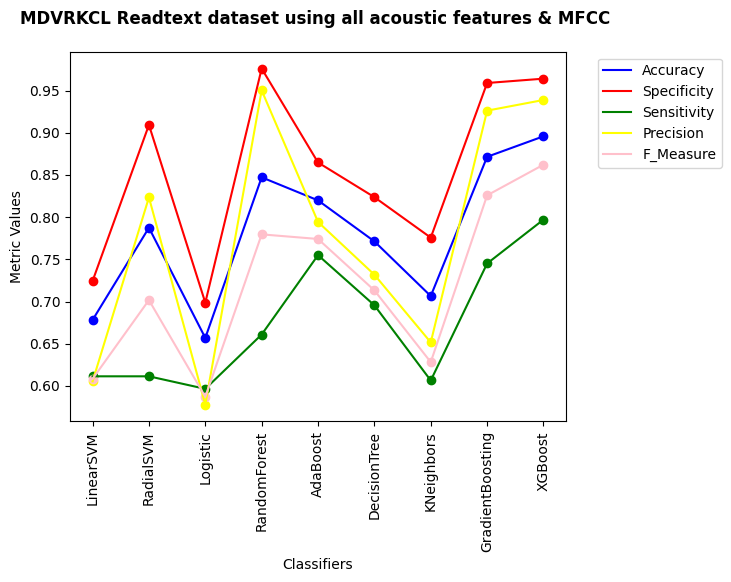

In [ ]:
plt.title("MDVRKCL Readtext dataset using all acoustic features, MFCC & Transformer Embeddings ",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score1['Classifier'], score1['Accuracy'], color='blue', label='Accuracy')
plt.plot(score1['Classifier'], score1['Specificity'], color='red', label='Specificity')
plt.plot(score1['Classifier'], score1['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score1['Classifier'], score1['Precision'], color='yellow', label='Precision')
plt.plot(score1['Classifier'], score1['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score1['Classifier'], score1['Accuracy'], color='blue')
plt.scatter(score1['Classifier'], score1['Specificity'], color='red')
plt.scatter(score1['Classifier'], score1['Sensitivity'], color='green')
plt.scatter(score1['Classifier'], score1['Precision'], color='yellow')
plt.scatter(score1['Classifier'], score1['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [113]:
# Checking the evaluation metrices while considering all the acoustic features & MFCC  selected using genetic algorithm for MDVRKCL Readtext dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe)
le = LabelEncoder()
le.fit(label_pd)
label = le.transform(label_pd)

score2 = Evaluate(X_imputed,label)
score2_sorted = score2.sort_values(by="Accuracy", ascending=False)


In [114]:
score2_sorted.reset_index(drop=True, inplace=True)
score2_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.895749,0.976027,0.779703,0.957447,0.859482
1,GradientBoosting,0.861336,0.952055,0.730198,0.913313,0.811554
2,RandomForest,0.848178,0.960616,0.685644,0.923333,0.786932
3,RadialSVM,0.823887,0.976027,0.603960,0.945736,0.737160
4,AdaBoost,0.823887,0.876712,0.747525,0.807487,0.776350
5,LinearSVM,0.804656,0.876712,0.700495,0.797183,0.745718
6,KNeighbors,0.804656,0.859589,0.725248,0.781333,0.752246
7,Logistic,0.785425,0.861301,0.675743,0.771186,0.720317
8,DecisionTree,0.784413,0.837329,0.707921,0.750656,0.728662


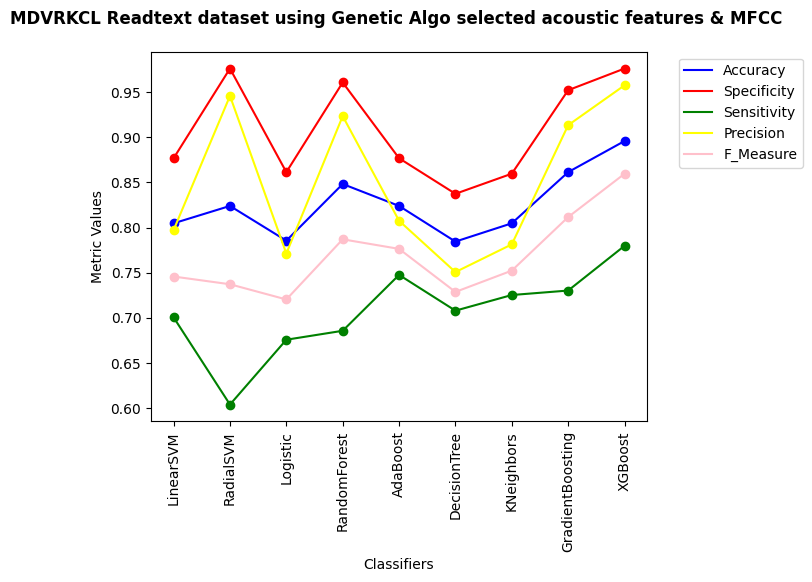

In [ ]:
plt.title("MDVRKCL Readtext dataset using Genetic Algo selected acoustic features, MFCC & Transformer Embeddings",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")

plt.xticks(rotation="vertical")
plt.plot(score2['Classifier'], score2['Accuracy'], color='blue', label='Accuracy')
plt.plot(score2['Classifier'], score2['Specificity'], color='red', label='Specificity')
plt.plot(score2['Classifier'], score2['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score2['Classifier'], score2['Precision'], color='yellow', label='Precision')
plt.plot(score2['Classifier'], score2['F Measure'] , color ='pink' , label = 'F_Measure')

plt.scatter(score2['Classifier'], score2['Accuracy'], color='blue')
plt.scatter(score2['Classifier'], score2['Specificity'], color='red')
plt.scatter(score2['Classifier'], score2['Sensitivity'], color='green')
plt.scatter(score2['Classifier'], score2['Precision'], color='yellow')
plt.scatter(score2['Classifier'], score2['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [116]:
# Checking the evaluation metrices while considering all the acoustic features for MDVRKCL Spontaneous dataset

imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dde1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score4 = Evaluate(X_imputed,label)
score4_sorted = score4.sort_values(by="Accuracy", ascending=False)
score4_sorted.reset_index(drop=True, inplace=True)
score4_sorted

,Classifier,Accuracy,Specificity,Sensitivity,Precision,F Measure
0,XGBoost,0.829295,0.903226,0.740291,0.864023,0.797386
1,RandomForest,0.811674,0.937500,0.660194,0.897690,0.760839
2,GradientBoosting,0.808370,0.903226,0.694175,0.856287,0.766756
3,RadialSVM,0.773128,0.929435,0.584951,0.873188,0.700581
4,AdaBoost,0.772026,0.828629,0.703883,0.773333,0.736976
5,DecisionTree,0.713656,0.703629,0.725728,0.670404,0.696970
6,Logistic,0.682819,0.717742,0.640777,0.653465,0.647059
7,LinearSVM,0.671806,0.683468,0.657767,0.633178,0.645238
8,KNeighbors,0.649780,0.659274,0.638350,0.608796,0.623223


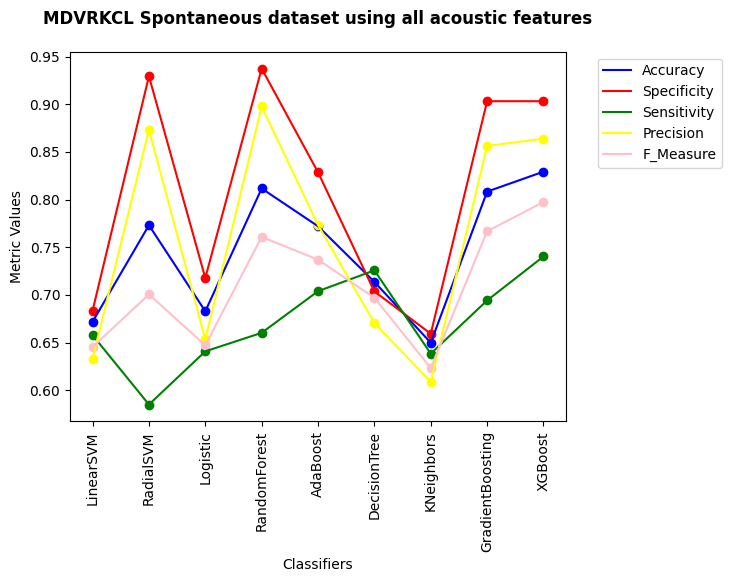

In [ ]:
plt.title("MDVRKCL Spontaneous dataset using all acoustic features, MFCC & Transformer Embeddings",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score4['Classifier'], score4['Accuracy'], color='blue', label='Accuracy')
plt.plot(score4['Classifier'], score4['Specificity'], color='red', label='Specificity')
plt.plot(score4['Classifier'], score4['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score4['Classifier'], score4['Precision'], color='yellow', label='Precision')
plt.plot(score4['Classifier'], score4['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score4['Classifier'], score4['Accuracy'], color='blue')
plt.scatter(score4['Classifier'], score4['Specificity'], color='red')
plt.scatter(score4['Classifier'], score4['Sensitivity'], color='green')
plt.scatter(score4['Classifier'], score4['Precision'], color='yellow')
plt.scatter(score4['Classifier'], score4['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


In [25]:
# Checking the evaluation metrices while considering all the acoustic features selected using genetic algorithm for MDVRKCL Spontaneous dataset
imputer = SimpleImputer(strategy="mean")
X_imputed = imputer.fit_transform(dfe1)
le = LabelEncoder()
le.fit(label_pd1)
label = le.transform(label_pd1)
score5 = Evaluate(X_imputed,label)
score5_sorted = score5.sort_values(by="Accuracy", ascending=False)
score5_sorted.reset_index(drop=True, inplace=True)
score5_sorted

In [ ]:
plt.title("MDVRKCL Spontaneous dataset using Genetic Algo selected acoustic features, MFCC & Transformer Embeddings",fontweight='bold', pad=20)

plt.xlabel("Classifiers")
plt.ylabel("Metric Values")
plt.xticks(rotation="vertical")
plt.plot(score5['Classifier'], score5['Accuracy'], color='blue', label='Accuracy')
plt.plot(score5['Classifier'], score5['Specificity'], color='red', label='Specificity')
plt.plot(score5['Classifier'], score5['Sensitivity'], color='green', label='Sensitivity')
plt.plot(score5['Classifier'], score5['Precision'], color='yellow', label='Precision')
plt.plot(score5['Classifier'], score5['F Measure'] , color ='pink' , label = 'F_Measure')
plt.scatter(score5['Classifier'], score5['Accuracy'], color='blue')
plt.scatter(score5['Classifier'], score5['Specificity'], color='red')
plt.scatter(score5['Classifier'], score5['Sensitivity'], color='green')
plt.scatter(score5['Classifier'], score5['Precision'], color='yellow')
plt.scatter(score5['Classifier'], score5['F Measure'] , color ='pink')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
